# Requirements

In [ ]:
%pip install torch==1.13.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1
%pip install scipy

# Imports

In [1]:
import torch
from torchsummary import summary
import os
import json
from scipy.io.wavfile import read as wavread
import warnings
warnings.filterwarnings("ignore")
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.distributed import DistributedSampler
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
import torchaudio
import librosa.display
import matplotlib.pyplot as plt
from math import cos, pi, floor, sin
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Configs

In [5]:
config = {
    'epochs'        : 50,
    'batch_size'    : 32,
    'init_lr'       : 2e-4
}

# Define Dataloaders

In [6]:
class CleanNoisyPairDataset(Dataset):
    """
    Create a Dataset of clean and noisy audio pairs.
    Each element is a tuple of the form (clean waveform, noisy waveform, file_id)
    """

    def __init__(self, root='./', subset='training', crop_length_sec=0):
        super(CleanNoisyPairDataset).__init__()

        assert subset is None or subset in ["training", "testing"]
        self.crop_length_sec = crop_length_sec
        self.subset = subset

        N_clean = len(os.listdir(os.path.join(root, 'clean')))
        N_noisy = len(os.listdir(os.path.join(root, 'noisy')))
        assert N_clean == N_noisy

        if subset == "training":
            self.files = [(os.path.join(root, 'clean', 'fileid_{}.wav'.format(i)),
                           os.path.join(root, 'noisy', 'fileid_{}.wav'.format(i))) for i in range(N_clean)]

        elif subset == "testing":
            sortkey = lambda name: '_'.join(name.split('_')[-2:])  # specific for dns due to test sample names
            _p = os.path.join("../DNS-Challenge", 'datasets/test_set/synthetic/no_reverb')  # path for DNS

            clean_files = os.listdir(os.path.join(_p, 'clean'))
            noisy_files = os.listdir(os.path.join(_p, 'noisy'))

            clean_files.sort(key=sortkey)
            noisy_files.sort(key=sortkey)

            self.files = []
            for _c, _n in zip(clean_files, noisy_files):
                assert sortkey(_c) == sortkey(_n)
                self.files.append((os.path.join(_p, 'clean', _c),
                                   os.path.join(_p, 'noisy', _n)))
            self.crop_length_sec = 0

        else:
            raise NotImplementedError

    def __getitem__(self, n):
        fileid = self.files[n]
        clean_audio, sample_rate = torchaudio.load(fileid[0])
        noisy_audio, sample_rate = torchaudio.load(fileid[1])
        clean_audio, noisy_audio = clean_audio.squeeze(0), noisy_audio.squeeze(0)
        assert len(clean_audio) == len(noisy_audio)

        crop_length = int(self.crop_length_sec * sample_rate)
        assert crop_length < len(clean_audio)

        # random crop
        if self.subset != 'testing' and crop_length > 0:
            start = np.random.randint(low=0, high=len(clean_audio) - crop_length + 1)
            clean_audio = clean_audio[start:(start + crop_length)]
            noisy_audio = noisy_audio[start:(start + crop_length)]

        transform = torchaudio.transforms.Spectrogram(n_fft=1024, win_length=1024, hop_length=256)

        clean_stft = transform(clean_audio)
        noisy_stft = transform(noisy_audio)

        clean_stft, noisy_stft = clean_stft.unsqueeze(1), noisy_stft.unsqueeze(1)
        return (clean_stft, noisy_stft, fileid)

    def __len__(self):
        return len(self.files)

In [7]:
def load_CleanNoisyPairDataset(root, subset, crop_length_sec, batch_size, sample_rate, num_gpus=1):
    """
    Get dataloader with distributed sampling
    """
    dataset = CleanNoisyPairDataset(root=root, subset=subset, crop_length_sec=crop_length_sec)
    kwargs = {"batch_size": batch_size, "num_workers": 4, "pin_memory": False, "drop_last": False}

    if num_gpus > 1:
        train_sampler = DistributedSampler(dataset)
        dataloader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, **kwargs)
    else:
        dataloader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, **kwargs)

    return dataloader

# Testing Data Loader Implementation

In [8]:
with open("/content/CleanSpecNet/configs/DNS-large-full.json") as f:
    data = f.read()

cleanspecnet_config = json.loads(data)
trainset_config = cleanspecnet_config["trainset_config"]

trainloader = load_CleanNoisyPairDataset(**trainset_config, subset='training', batch_size=config['batch_size'], num_gpus=1)
testloader = load_CleanNoisyPairDataset(**trainset_config, subset='testing', batch_size=config['batch_size'], num_gpus=1)

print(len(trainloader), len(testloader))

for clean_audio, noisy_audio, fileid in trainloader:
    clean_audio = clean_audio.cuda()
    noisy_audio = noisy_audio.cuda()
    print(clean_audio.shape, noisy_audio.shape, fileid)
    break

376 5
torch.Size([32, 513, 1, 626]) torch.Size([32, 513, 1, 626]) [('../training_set/clean/fileid_670.wav', '../training_set/clean/fileid_3484.wav', '../training_set/clean/fileid_392.wav', '../training_set/clean/fileid_1341.wav', '../training_set/clean/fileid_10066.wav', '../training_set/clean/fileid_7502.wav', '../training_set/clean/fileid_2978.wav', '../training_set/clean/fileid_272.wav', '../training_set/clean/fileid_4885.wav', '../training_set/clean/fileid_5229.wav', '../training_set/clean/fileid_11647.wav', '../training_set/clean/fileid_8319.wav', '../training_set/clean/fileid_5539.wav', '../training_set/clean/fileid_9236.wav', '../training_set/clean/fileid_1417.wav', '../training_set/clean/fileid_202.wav', '../training_set/clean/fileid_9811.wav', '../training_set/clean/fileid_2283.wav', '../training_set/clean/fileid_11221.wav', '../training_set/clean/fileid_7159.wav', '../training_set/clean/fileid_7575.wav', '../training_set/clean/fileid_1250.wav', '../training_set/clean/fileid_1

# Define Model Architecture

In [9]:
class ConvBlock(torch.nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=1, padding="same")
    self.relu = torch.nn.ReLU()
    self.conv2 = torch.nn.Conv1d(out_channels, out_channels * 2, kernel_size=4, stride=1, padding="same")
    self.glu = torch.nn.GLU(dim=1)


  def forward(self, x):

    x_conv1 = self.conv1(x)
    x_relu = self.relu(x_conv1)
    x_conv2 = self.conv2(x_relu)
    output = self.glu(x_conv2)

    return output

In [10]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = torch.nn.Dropout(attn_dropout)

    def forward(self, q, k, v):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output

In [11]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head=8, d_model=512, d_k=64, d_v=64, dropout=0):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = torch.nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = torch.nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = torch.nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = torch.nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = torch.nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        q = self.attention(q, k, v)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q

In [12]:
class PositionwiseFeedForward(torch.nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in=512, d_hid=2048, dropout=0):
        super().__init__()
        self.w_1 = torch.nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = torch.nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = torch.nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [13]:
class EncoderLayer(torch.nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.0):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output = self.slf_attn(
            enc_input, enc_input, enc_input)
        enc_output = self.pos_ffn(enc_output)
        return enc_output

In [14]:
class TransformerEncoder(torch.nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, d_word_vec=512, n_layers=2, n_head=8, d_k=64, d_v=64,
            d_model=512, d_inner=2048, dropout=0, scale_emb=False):

        super().__init__()

        self.dropout = torch.nn.Dropout(p=dropout)
        self.layer_stack = torch.nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = torch.nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask=None, return_attns=False):

        # -- Forward
        # enc_output = self.src_word_emb(src_seq)
        enc_output = src_seq
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(enc_output)
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output = enc_layer(enc_output, slf_attn_mask=src_mask)

        return enc_output

In [15]:
class CleanSpecNet(torch.nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1x1_1 = torch.nn.Conv2d(513, 513, kernel_size=1, stride=1, padding=0)

    self.encoder = torch.nn.Sequential(
        ConvBlock(513, 64),
        ConvBlock(64, 64),
        ConvBlock(64, 64),
        ConvBlock(64, 64),
        ConvBlock(64, 64)
    )

    self.attn = TransformerEncoder(n_layers=5)

    self.attn_conv1 = torch.nn.Conv1d(64, 512, kernel_size=1, stride=1, padding=0)
    self.attn_conv2 = torch.nn.Conv1d(512, 64, kernel_size=1, stride=1, padding=0)

    self.conv1x1_2 = torch.nn.Conv2d(64, 513, kernel_size=1, stride=1, padding=0)


  def forward(self, x):
    x_conv1 = self.conv1x1_1(x)

    bs, c, h, w = x_conv1.size()
    x_conv1_flattened = torch.reshape(x_conv1, (bs, c, h * w))

    x_encoded = self.encoder(x_conv1_flattened)

    x_attn_conv1 = self.attn_conv1(x_encoded)

    x_attn_conv1 = x_attn_conv1.permute(0, 2, 1)
    x_attn = self.attn(x_attn_conv1)
    x_attn = x_attn.permute(0, 2, 1)

    x_attn_conv2 = self.attn_conv2(x_attn)

    bs, c, w = x_attn_conv2.size()
    x_conv2_unflattened = torch.reshape(x_attn_conv2, (bs, c, 1, w))

    output = self.conv1x1_2(x_conv2_unflattened)
    output = output.squeeze(-2)
    # print("##########SHAPE", output.size())

    return output

In [16]:
model = CleanSpecNet().to(DEVICE)
summary(model, (513, 1, 626))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 513, 1, 626]         263,682
            Conv1d-2              [-1, 64, 626]         131,392
              ReLU-3              [-1, 64, 626]               0
            Conv1d-4             [-1, 128, 626]          32,896
               GLU-5              [-1, 64, 626]               0
         ConvBlock-6              [-1, 64, 626]               0
            Conv1d-7              [-1, 64, 626]          16,448
              ReLU-8              [-1, 64, 626]               0
            Conv1d-9             [-1, 128, 626]          32,896
              GLU-10              [-1, 64, 626]               0
        ConvBlock-11              [-1, 64, 626]               0
           Conv1d-12              [-1, 64, 626]          16,448
             ReLU-13              [-1, 64, 626]               0
           Conv1d-14             [-1, 1

# Define Loss Function

In [17]:
class SpecLoss(torch.nn.Module):

  def __init__(self):
    super().__init__()


  def forward(self, y, y_hat):
    # Calculate the loss
    y_hat = torch.abs(y_hat)
    # print("ABS val", y_hat)
    log_term = torch.norm((torch.log(y + 1e-8) - torch.log(y_hat + 1e-8)), p=1, dim=(1,2))  # Adding epsilon to avoid log(0)
    # print("log_term", log_term)
    consistency_term = torch.norm(y - y_hat, p='fro', dim=(1,2))
    # print("consistency_term", consistency_term)
    y_true_norm = torch.norm(y, p='fro', dim=(1,2))
    # print("y_true_norm", y_true_norm)
    loss = (consistency_term / y_true_norm)

    # print("LOSS SHAPE", loss.size())

    loss = torch.mean(loss)

    # print("Test loss", loss)

    return loss


# Define Scheduler

In [18]:
# Describe MIT license

def anneal_linear(start, end, proportion):
    return start + proportion * (end - start)


def anneal_cosine(start, end, proportion):
    cos_val = cos(pi * proportion) + 1
    return end + (start - end) / 2 * cos_val


class Phase:
    def __init__(self, start, end, n_iter, cur_iter, anneal_fn):
        self.start, self.end = start, end
        self.n_iter = n_iter
        self.anneal_fn = anneal_fn
        self.n = cur_iter

    def step(self):
        self.n += 1

        return self.anneal_fn(self.start, self.end, self.n / self.n_iter)

    def reset(self):
        self.n = 0

    @property
    def is_done(self):
        return self.n >= self.n_iter

class LinearWarmupCosineDecay:
    def __init__(
        self,
        optimizer,
        lr_max,
        n_iter,
        iteration=0,
        divider=25,
        warmup_proportion=0.3,
        phase=('linear', 'cosine'),
    ):
        self.optimizer = optimizer

        phase1 = int(n_iter * warmup_proportion)
        phase2 = n_iter - phase1
        lr_min = lr_max / divider

        phase_map = {'linear': anneal_linear, 'cosine': anneal_cosine}

        cur_iter_phase1 = iteration
        cur_iter_phase2 = max(0, iteration - phase1)
        self.lr_phase = [
            Phase(lr_min, lr_max, phase1, cur_iter_phase1, phase_map[phase[0]]),
            Phase(lr_max, lr_min / 1e4, phase2, cur_iter_phase2, phase_map[phase[1]]),
        ]

        if iteration < phase1:
            self.phase = 0
        else:
            self.phase = 1

    def step(self):
        lr = self.lr_phase[self.phase].step()

        for group in self.optimizer.param_groups:
            group['lr'] = lr

        if self.lr_phase[self.phase].is_done:
            self.phase += 1

        if self.phase >= len(self.lr_phase):
            for phase in self.lr_phase:
                phase.reset()

            self.phase = 0

        return lr

# Loss, Optimizer

In [19]:
criterion = SpecLoss() # Defining Loss function.

optimizer = torch.optim.Adam(model.parameters(), lr=config["init_lr"])

iterations = 1




# Load from checkpoint

In [20]:
chkpt_loss = float("inf")

In [ ]:
# checkpoint = torch.load('specnet_checkpoints/checkpoint_110_batch16.pth')

# iterations = checkpoint['iterations']

# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# chkpt_loss = checkpoint['loss']

In [21]:
print(chkpt_loss)

inf


# Scheduler

In [22]:
scheduler = LinearWarmupCosineDecay(
                    optimizer,
                    lr_max=config['init_lr'],
                    n_iter=config['epochs'] * config['batch_size'],
                    iteration=iterations,
                    divider=25,
                    warmup_proportion=0.05,
                    phase=('linear', 'cosine'),
                )

# Training

In [23]:
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(trainloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (clean_stft, noisy_stft, _) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        ### Move Data to Device (Ideally GPU)
        clean_stft = clean_stft.to(DEVICE)
        noisy_stft = noisy_stft.to(DEVICE)

        ### Forward Propagation
        pred_stft  = model(noisy_stft)

        ### Loss Calculation
        clean_stft = clean_stft.squeeze(-2)
        loss    = criterion(clean_stft, pred_stft)

        ### Backward Propagation
        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1e9)

        scheduler.step() # SEE IF THIS SHOULD BE HERE. CLEANUNET IMPL

        ### Gradient Descent
        optimizer.step()

        # print("LOSS ITEM", loss.item())
        tloss   += loss.item()
        # tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))))
        batch_bar.update()

        ### Release memory
        del clean_stft, noisy_stft, pred_stft
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss   /= len(trainloader)
    # tacc    /= len(trainloader)

    return tloss

In [ ]:
wandb.login(key="8e00abb67ba14a9fe0b7208b48a9200ac1fcf91c")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "batch-32-graph-run", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    project = "idl-project", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

loss,▆▇▅█▅▆▅▆▄▃▇▆▅▇▇▆▆▄▄▄▄▅▃▄▃▃▂▃▂▂▃▄▂▁▁▂▂▁▁▁
lr,▇█▁▂▄▅▇█▁▁▂▄▆▇█▁▂▄▅▆█▁▁▂▅▆▇█▁▂▃▅▇█▂▁▃▅▆█
loss,0.19056
lr,0.0002


# Experimentation

In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

best_loss = chkpt_loss

for epoch in range(50):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss   = train(model, trainloader, optimizer, criterion)
    # scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))

    ### Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'loss': train_loss, 'lr': curr_lr})

    print({'train_loss': train_loss, 'lr': curr_lr, 'iterations': ((epoch + 1) * config['batch_size'])})

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    if (epoch + 1) % 10 == 0 and train_loss <= best_loss:
      best_loss = train_loss
      torch.save({
                'iterations'              : ((epoch + 1) * config['batch_size']),
                'model_state_dict'        : model.state_dict(),
                'optimizer_state_dict'    : optimizer.state_dict(),
                'loss'                    : train_loss,
                # 'scheduler_state_dict'    : scheduler.state_dict()
      }, 'specnet_checkpoints/checkpoint_{}.pth'.format(epoch + 1))

    #### For generating STOI and PESQ graphs
    # if epoch % 2 == 0:
    #   best_loss = train_loss
    #   torch.save({
    #             'iterations'              : epoch,
    #             'model_state_dict'        : model.state_dict(),
    #             'optimizer_state_dict'    : optimizer.state_dict(),
    #             'loss'                    : train_loss,
    #             # 'scheduler_state_dict'    : scheduler.state_dict()
    #   }, 'specnet_checkpoints/checkpoint_{}_batch32_graph.pth'.format(epoch))

### Finish your wandb run
#run.finish()


Epoch 1/50


	Train Loss 0.9628	 Learning Rate 0.0002000
{'train_loss': 0.9627713186943785, 'lr': 0.0002, 'iterations': 32}

Epoch 2/50


	Train Loss 0.9272	 Learning Rate 0.0001817
{'train_loss': 0.9272305050745924, 'lr': 0.0001817436753394476, 'iterations': 64}

Epoch 3/50


	Train Loss 0.8950	 Learning Rate 0.0001179
{'train_loss': 0.8949735919211773, 'lr': 0.00011788506890996289, 'iterations': 96}

Epoch 4/50


	Train Loss 0.8726	 Learning Rate 0.0000438
{'train_loss': 0.8725763778103158, 'lr': 4.375810316892282e-05, 'iterations': 128}

Epoch 5/50


	Train Loss 0.8602	 Learning Rate 0.0000019
{'train_loss': 0.8601687671022212, 'lr': 1.9222642737891184e-06, 'iterations': 160}

Epoch 6/50


	Train Loss 0.7989	 Learning Rate 0.0001915
{'train_loss': 0.798892450776506, 'lr': 0.00019149414723989094, 'iterations': 192}

Epoch 7/50


	Train Loss 0.7525	 Learning Rate 0.0001369
{'train_loss': 0.7525397153927925, 'lr': 0.00013692798102366049, 'iterations': 224}

Epoch 8/50


	Train Loss 0.7269	 Learning Rate 0.0000612
{'train_loss': 0.726884441331346, 'lr': 6.116009883681524e-05, 'iterations': 256}

Epoch 9/50


	Train Loss 0.7209	 Learning Rate 0.0000077
{'train_loss': 0.7208834252458938, 'lr': 7.692107697459839e-06, 'iterations': 288}

Epoch 10/50


	Train Loss 0.6821	 Learning Rate 0.0001977
{'train_loss': 0.682130865435651, 'lr': 0.0001976543982541578, 'iterations': 320}

Epoch 11/50


	Train Loss 0.6377	 Learning Rate 0.0001545
{'train_loss': 0.637652650634025, 'lr': 0.00015452185233766813, 'iterations': 352}

Epoch 12/50


	Train Loss 0.6140	 Learning Rate 0.0000801
{'train_loss': 0.613963763288995, 'lr': 8.008619057321642e-05, 'iterations': 384}

Epoch 13/50


	Train Loss 0.6085	 Learning Rate 0.0000171
{'train_loss': 0.608464499261785, 'lr': 1.708413481115839e-05, 'iterations': 416}

Epoch 14/50


	Train Loss 0.5971	 Learning Rate 0.0002000
{'train_loss': 0.5970607663088656, 'lr': 0.00019998269971200893, 'iterations': 448}

Epoch 15/50


	Train Loss 0.5575	 Learning Rate 0.0001700
{'train_loss': 0.5575040588353543, 'lr': 0.0001699762981408358, 'iterations': 480}

Epoch 16/50


	Train Loss 0.5312	 Learning Rate 0.0000998
{'train_loss': 0.5311715633786739, 'lr': 9.979371724667694e-05, 'iterations': 512}

Epoch 17/50


	Train Loss 0.5229	 Learning Rate 0.0000297
{'train_loss': 0.5228730189673444, 'lr': 2.9729801829933806e-05, 'iterations': 544}

Epoch 18/50


	Train Loss 0.5285	 Learning Rate 0.0000000
{'train_loss': 0.5285040402507528, 'lr': 1.1265725535900944e-08, 'iterations': 576}

Epoch 19/50


	Train Loss 0.4973	 Learning Rate 0.0001827
{'train_loss': 0.4972886519229158, 'lr': 0.00018268488492507532, 'iterations': 608}

Epoch 20/50


	Train Loss 0.4779	 Learning Rate 0.0001195
{'train_loss': 0.47790788248815436, 'lr': 0.00011950935416548405, 'iterations': 640}

Epoch 21/50


	Train Loss 0.4679	 Learning Rate 0.0000451
{'train_loss': 0.4679336999642088, 'lr': 4.513289191689774e-05, 'iterations': 672}

Epoch 22/50


	Train Loss 0.4762	 Learning Rate 0.0000023
{'train_loss': 0.4761600077469298, 'lr': 2.258231035912382e-06, 'iterations': 704}

Epoch 23/50


	Train Loss 0.4606	 Learning Rate 0.0001921
{'train_loss': 0.46058037124098616, 'lr': 0.00019214892687760728, 'iterations': 736}

Epoch 24/50


	Train Loss 0.4365	 Learning Rate 0.0001385
{'train_loss': 0.4365341893218933, 'lr': 0.00013845945839134396, 'iterations': 768}

Epoch 25/50


	Train Loss 0.4258	 Learning Rate 0.0000627
{'train_loss': 0.42579566576379413, 'lr': 6.268898676577092e-05, 'iterations': 800}

Epoch 26/50


	Train Loss 0.4308	 Learning Rate 0.0000083
{'train_loss': 0.4308033044985, 'lr': 8.340605727379953e-06, 'iterations': 832}

Epoch 27/50


	Train Loss 0.4357	 Learning Rate 0.0001980
{'train_loss': 0.43572022940250155, 'lr': 0.00019799705434628983, 'iterations': 864}

Epoch 28/50


	Train Loss 0.4051	 Learning Rate 0.0001559
{'train_loss': 0.40507019263632754, 'lr': 0.00015590042654108218, 'iterations': 896}

Epoch 29/50


	Train Loss 0.3935	 Learning Rate 0.0000817
{'train_loss': 0.3934710655916244, 'lr': 8.170918401647343e-05, 'iterations': 928}

Epoch 30/50


	Train Loss 0.3910	 Learning Rate 0.0000180
{'train_loss': 0.39100295701559556, 'lr': 1.8019717001921057e-05, 'iterations': 960}

Epoch 31/50


	Train Loss 0.4088	 Learning Rate 0.0002000
{'train_loss': 0.4087570609643738, 'lr': 0.00019999978641011495, 'iterations': 992}

Epoch 32/50


	Train Loss 0.3890	 Learning Rate 0.0001711
{'train_loss': 0.38896372153403913, 'lr': 0.00017114787383415021, 'iterations': 1024}

Epoch 33/50


	Train Loss 0.3690	 Learning Rate 0.0001014
{'train_loss': 0.3689985769860288, 'lr': 0.00010144712983075202, 'iterations': 1056}

Epoch 34/50


	Train Loss 0.3645	 Learning Rate 0.0000309
{'train_loss': 0.36454306051452107, 'lr': 3.0915755872519643e-05, 'iterations': 1088}

Epoch 35/50


	Train Loss 0.3803	 Learning Rate 0.0000000
{'train_loss': 0.3802672005555731, 'lr': 4.8853892112059885e-08, 'iterations': 1120}

Epoch 36/50


	Train Loss 0.3653	 Learning Rate 0.0001836
{'train_loss': 0.3653250215376945, 'lr': 0.00018360348939812395, 'iterations': 1152}

Epoch 37/50


	Train Loss 0.3478	 Learning Rate 0.0001211
{'train_loss': 0.3478090896251354, 'lr': 0.00012112830586773204, 'iterations': 1184}

Epoch 38/50


	Train Loss 0.3408	 Learning Rate 0.0000465
{'train_loss': 0.3407824022814314, 'lr': 4.6522680893733885e-05, 'iterations': 1216}

Epoch 39/50


	Train Loss 0.3577	 Learning Rate 0.0000026
{'train_loss': 0.35767350512299134, 'lr': 2.6209195310809276e-06, 'iterations': 1248}

Epoch 40/50


	Train Loss 0.3505	 Learning Rate 0.0001928
{'train_loss': 0.3505435779373697, 'lr': 0.0001927785140281726, 'iterations': 1280}

Epoch 41/50


	Train Loss 0.3348	 Learning Rate 0.0001400
{'train_loss': 0.3348351189906293, 'lr': 0.0001399804214364746, 'iterations': 1312}

Epoch 42/50


	Train Loss 0.3256	 Learning Rate 0.0000642
{'train_loss': 0.32561955497937, 'lr': 6.422807526255267e-05, 'iterations': 1344}

Epoch 43/50


	Train Loss 0.3341	 Learning Rate 0.0000090
{'train_loss': 0.33413994399474023, 'lr': 9.014162629836839e-06, 'iterations': 1376}

Epoch 44/50


	Train Loss 0.3392	 Learning Rate 0.0001983
{'train_loss': 0.339234618747488, 'lr': 0.00019831291913161408, 'iterations': 1408}

Epoch 45/50


	Train Loss 0.3254	 Learning Rate 0.0001573
{'train_loss': 0.3253918539019341, 'lr': 0.0001572637182353982, 'iterations': 1440}

Epoch 46/50


	Train Loss 0.3134	 Learning Rate 0.0000833
{'train_loss': 0.3133770506432716, 'lr': 8.333717809554373e-05, 'iterations': 1472}

Epoch 47/50


	Train Loss 0.3111	 Learning Rate 0.0000190
{'train_loss': 0.3110844662531893, 'lr': 1.8977711892843362e-05, 'iterations': 1504}

Epoch 48/50


	Train Loss 0.3356	 Learning Rate 0.0001832
{'train_loss': 0.3356231297267244, 'lr': 0.0001832, 'iterations': 1536}

Epoch 49/50


	Train Loss 0.3155	 Learning Rate 0.0001723
{'train_loss': 0.31548087921072826, 'lr': 0.00017229999851852147, 'iterations': 1568}

Epoch 50/50


	Train Loss 0.3045	 Learning Rate 0.0001031
{'train_loss': 0.3044690701397175, 'lr': 0.0001031001468933369, 'iterations': 1600}


In [ ]:
torch.save({
                'iterations'              : ((epoch + 1) * config['batch_size']),
                'model_state_dict'        : model.state_dict(),
                'optimizer_state_dict'    : optimizer.state_dict(),
                'loss'                    : train_loss,
                # 'scheduler_state_dict'    : scheduler.state_dict()
      }, 'specnet_checkpoints/checkpoint_{}.pth'.format(epoch + 1))

In [ ]:
print(epoch + 1)

50


# Load from checkpoint

In [ ]:
# checkpoint = torch.load('checkpoint_2.pth')

# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Inference

In [ ]:
import IPython.display as ipd
from scipy.io.wavfile import write

def test(model, testloader):
    model.eval()

    test_predictions = []

    pred_test = None

    sortkey = lambda name: '_'.join(name.split('/')[-1].split('_')[1:])
    transform = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=1024, hop_length=256)

    with torch.inference_mode(): # TODO

        for i, (clean_stft, noisy_stft, fileid) in enumerate(tqdm(testloader)):

            noisy_stft   = noisy_stft.to(DEVICE)

            filename = sortkey(fileid[0][0])

            pred_stft  = model(noisy_stft)
            pred_test = pred_stft
            waveform = transform(torch.abs(pred_test).detach().cpu())
            audio_numpy = waveform.numpy()
            write(os.path.join("generated_audio", 'enhanced_{}'.format(filename)), 16000, audio_numpy[0])

            test_predictions.extend(pred_stft)

    return test_predictions, pred_test

In [ ]:
ret_vals, pred_test = test(model, testloader)


  0%|          | 0/19 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_264.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp492_vacuum_195835_4_snr7_tl-33_fileid_264.wav



  5%|▌         | 1/19 [00:02<00:47,  2.64s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_206.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp642_atRfc2R9SdU_snr13_tl-33_fileid_206.wav



 11%|█         | 2/19 [00:04<00:41,  2.47s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_213.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp246_door_83878_0_snr15_tl-26_fileid_213.wav



 16%|█▌        | 3/19 [00:07<00:37,  2.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_165.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp517_wind_112296_1_snr6_tl-30_fileid_165.wav



 21%|██        | 4/19 [00:09<00:34,  2.29s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_3.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp238_washer_389769_1_snr11_tl-20_fileid_3.wav



 26%|██▋       | 5/19 [00:11<00:31,  2.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_47.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp199_birds_413745_9_snr13_tl-31_fileid_47.wav



 32%|███▏      | 6/19 [00:13<00:29,  2.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_116.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp30_birds_121947_2_snr6_tl-27_fileid_116.wav



 37%|███▋      | 7/19 [00:16<00:26,  2.24s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_9.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp81_car_74675_2_snr18_tl-22_fileid_9.wav



 42%|████▏     | 8/19 [00:18<00:24,  2.23s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_271.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp44_wind_97396_2_snr14_tl-26_fileid_271.wav



 47%|████▋     | 9/19 [00:20<00:22,  2.22s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_166.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp352_clatter_noise_431472__debsound__retro-bicycle-minsk-aist-20-ride-loop-rear-wheel_0_snr18_tl-33_fileid_166.wav



 53%|█████▎    | 10/19 [00:22<00:20,  2.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_169.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp524_train_181130_1_snr6_tl-18_fileid_169.wav



 58%|█████▊    | 11/19 [00:25<00:18,  2.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 63%|██████▎   | 12/19 [00:27<00:15,  2.27s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_241.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp287_baby_416650_0_snr12_tl-34_fileid_241.wav



 68%|██████▊   | 13/19 [00:29<00:13,  2.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_155.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp236_d11XSGiWtd0_snr10_tl-33_fileid_155.wav



 74%|███████▎  | 14/19 [00:31<00:11,  2.24s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_49.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp283_birds_121947_1_snr2_tl-26_fileid_49.wav



 79%|███████▉  | 15/19 [00:34<00:09,  2.28s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



 84%|████████▍ | 16/19 [00:36<00:06,  2.27s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_21.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp169_babble_188218_7_snr15_tl-19_fileid_21.wav



 89%|████████▉ | 17/19 [00:38<00:04,  2.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_181.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp399_squeaky_213909_0_snr10_tl-30_fileid_181.wav



 95%|█████████▍| 18/19 [00:40<00:02,  2.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_45.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp312_Vi5bENnLJPs_snr15_tl-20_fileid_45.wav



100%|██████████| 19/19 [00:42<00:00,  2.23s/it]


In [ ]:
len(ret_vals)

32

In [ ]:
print(ret_vals[0])
print(pred_test.shape)

tensor([[ 1.7517e+00,  1.9400e+00,  2.9550e+00,  ...,  2.7543e+00,
          2.3914e+00,  2.7913e+00],
        [-3.2704e+00, -3.6274e+00, -5.5686e+00,  ..., -5.0068e+00,
         -4.4586e+00, -5.1683e+00],
        [ 3.1612e+00,  3.4875e+00,  5.3657e+00,  ...,  4.9246e+00,
          4.2989e+00,  4.8791e+00],
        ...,
        [ 2.1823e-03,  1.4252e-03,  1.3087e-03,  ...,  6.1606e-03,
          2.1938e-02,  6.1547e-02],
        [-3.2308e-03, -1.8771e-03, -1.9813e-03,  ..., -6.8485e-03,
         -2.3644e-02, -6.3337e-02],
        [-2.7859e-03, -1.8822e-03, -1.9489e-03,  ..., -8.1963e-03,
         -2.2717e-02, -6.1942e-02]], device='cuda:0')
torch.Size([32, 513, 626])


In [ ]:
# transform = torchaudio.transforms.InverseSpectrogram(n_fft=1024, win_length=1024, hop_length=256)
transform = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=1024, hop_length=256)

In [ ]:
waveform = transform(torch.abs(pred_test).detach().cpu())

In [ ]:
print(waveform.shape)

torch.Size([6, 160000])


In [ ]:
import IPython.display as ipd

In [ ]:
audio_numpy = waveform[0].numpy()

# Playing the audio
ipd.display(ipd.Audio(audio_numpy, rate=16000))

In [ ]:
from scipy.io.wavfile import write
write('fifth_inference.wav', 16000, audio_numpy)

In [ ]:
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import argparse
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.io import wavfile

from pesq import pesq
from pystoi import stoi

result = defaultdict(int)
# /content/DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp470_8TQfuL-u2rA_snr8_tl-21_fileid_142.wav

rate, clean = wavfile.read(os.path.join('../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_261.wav'))
# rate, noisy = wavfile.read(os.path.join('../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp470_8TQfuL-u2rA_snr8_tl-21_fileid_142.wav'))
rate, target_wav = wavfile.read(os.path.join('fifth_inference.wav'))

length = target_wav.shape[-1]

result['pesq_wb'] += pesq(16000, clean, target_wav, 'wb')  # wide band
result['pesq_nb'] += pesq(16000, clean, target_wav, 'nb')  # narrow band
result['stoi'] += stoi(clean, target_wav, rate)
result['count'] += 1 * length
print(result)

defaultdict(<class 'int'>, {'pesq_wb': 1.0659385919570923, 'pesq_nb': 1.237579107284546, 'stoi': 0.6949048436036707, 'count': 160000})


In [ ]:
print(result)

defaultdict(<class 'int'>, {'pesq_wb': 1.0445079803466797, 'pesq_nb': 1.232287049293518, 'stoi': 0.6331833949033348, 'count': 160000})


In [ ]:
result = defaultdict(int)
for i in tqdm(range(300)):
  try:
      rate, clean = wavfile.read(os.path.join('../DNS-Challenge/datasets/test_set/synthetic/no_reverb', "clean", "clean_fileid_{}.wav".format(i)))
      rate, target_wav = wavfile.read(os.path.join('generated_audio', "enhanced_fileid_{}.wav".format(i)))
      print(os.path.join('../DNS-Challenge/datasets/test_set/synthetic/no_reverb', "clean", "clean_fileid_{}.wav".format(i)))
      print(os.path.join('generated_audio', "enhanced_fileid_{}.wav".format(i)))
  except:
      continue
  length = target_wav.shape[-1]
  result['pesq_wb'] += pesq(16000, clean, target_wav, 'wb')  # wide band
  result['pesq_nb'] += pesq(16000, clean, target_wav, 'nb')  # narrow band
  result['stoi'] += stoi(clean, target_wav, rate)
  result['count'] += 1

print("\n")
print('pesq_wb', (result['pesq_wb']/result['count']))
print('pesq_nb', result['pesq_nb']/result['count'])
print('stoi', result['stoi']/result['count'])

In [ ]:
import IPython.display as ipd
from scipy.io.wavfile import write

def test(model, testloader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    pred_test = None

    sortkey = lambda name: '_'.join(name.split('/')[-1].split('_')[1:])
    transform = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=1024, hop_length=256)

    with torch.inference_mode(): # TODO

        for i, (clean_stft, noisy_stft, fileid) in enumerate(tqdm(testloader)):

            noisy_stft   = noisy_stft.to(DEVICE)
            print('\n')
            print(fileid[0][0])
            print(fileid[1][0])

            filename = sortkey(fileid[0][0])
            # print(filename)

            pred_stft  = model(noisy_stft)
            pred_test = pred_stft
            waveform = transform(torch.abs(pred_test).detach().cpu())
            audio_numpy = waveform.numpy()
            write(os.path.join("generated_audio", 'enhanced_{}'.format(filename)), 16000, audio_numpy[0])



            ### Get most likely predicted phoneme with argmax

            test_predictions.extend(pred_stft)

    return test_predictions, pred_test

# Graphs

In [54]:
import IPython.display as ipd
from scipy.io.wavfile import write

def test(model, testloader, batch_size):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    pred_test = None

    sortkey = lambda name: '_'.join(name.split('/')[-1].split('_')[1:])
    transform = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=1024, hop_length=256)

    with torch.inference_mode(): # TODO

        for i, (clean_stft, noisy_stft, fileid) in enumerate(tqdm(testloader)):

            noisy_stft   = noisy_stft.to(DEVICE)
            print('\n')
            print(fileid[0][0])
            print(fileid[1][0])

            filename = sortkey(fileid[0][0])
            # print(filename)

            pred_stft  = model(noisy_stft)
            pred_test = pred_stft
            waveform = transform(torch.abs(pred_test).detach().cpu())
            audio_numpy = waveform.numpy()
            write(os.path.join("generated_audio/batch_{}".format(batch_size), 'enhanced_{}'.format(filename)), 16000, audio_numpy[0])



            ### Get most likely predicted phoneme with argmax

            test_predictions.extend(pred_stft)

    return test_predictions, pred_test

In [55]:
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import argparse
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.io import wavfile

from pesq import pesq
from pystoi import stoi


def audio_eval(batch_size):
  result = defaultdict(int)
  for i in range(300):
    try:
        rate, clean = wavfile.read(os.path.join('../DNS-Challenge/datasets/test_set/synthetic/no_reverb', "clean", "clean_fileid_{}.wav".format(i)))
        rate, target_wav = wavfile.read(os.path.join('generated_audio/batch_{}'.format(batch_size), "enhanced_fileid_{}.wav".format(i)))
    except:
        continue
    length = target_wav.shape[-1]
    result['pesq_wb'] += pesq(16000, clean, target_wav, 'wb')  # wide band
    result['pesq_nb'] += pesq(16000, clean, target_wav, 'nb')  # narrow band
    result['stoi'] += stoi(clean, target_wav, rate)
    result['count'] += 1
    os.remove(os.path.join('generated_audio/batch_{}'.format(batch_size), "enhanced_fileid_{}.wav".format(i)))

  print("\n")
  print('pesq_wb', (result['pesq_wb']/result['count']))
  print('pesq_nb', result['pesq_nb']/result['count'])
  print('stoi', result['stoi']/result['count'])

  return result

In [56]:
import json

batch_sizes = [8, 16, 32]
final_res = {}

for batch_size in tqdm(batch_sizes):
  print("Batch Size: ", batch_size)
  key_val = "batch_{}".format(batch_size)
  for i in range(0,50,2):

    checkpoint = torch.load('specnet_checkpoints/graph_{}/checkpoint_{}_batch{}_graph.pth'.format(batch_size, i, batch_size))

    iterations = checkpoint['iterations']

    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    chkpt_loss = checkpoint['loss']

    test(model, testloader, batch_size)

    batch_res = audio_eval(batch_size)

    if key_val not in final_res:
      final_res[key_val] = {}
      final_res[key_val]['pesq_wb'] = []
      final_res[key_val]['pesq_nb'] = []
      final_res[key_val]['stoi'] = []

    final_res[key_val]['pesq_wb'].append(batch_res['pesq_wb'])
    final_res[key_val]['pesq_nb'].append(batch_res['pesq_nb'])
    final_res[key_val]['stoi'].append(batch_res['stoi'])

    print(final_res)
  with open('final_res.json', 'w') as output_f:
    json.dump(final_res, output_f)




  0%|          | 0/3 [00:00<?, ?it/s]

Batch Size:  8



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_19.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav



 20%|██        | 1/5 [00:16<01:04, 16.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_277.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp47_fan_out_83867_5_snr4_tl-34_fileid_277.wav



 40%|████      | 2/5 [00:31<00:47, 15.67s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_67.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp46_dryer_output_83885_2_snr0_tl-31_fileid_67.wav



 60%|██████    | 3/5 [00:47<00:31, 15.74s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_117.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp76_babble_188218_0_snr18_tl-28_fileid_117.wav



 80%|████████  | 4/5 [01:02<00:15, 15.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



100%|██████████| 5/5 [01:13<00:00, 14.68s/it]




pesq_wb 1.2879304885864258
pesq_nb 1.4986266136169433
stoi 0.7071855902121971
{'batch_8': {'pesq_wb': [5.439652442932129], 'pesq_nb': [6.493133068084717], 'stoi': [3.5359279510609856]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_268.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp102_traffic_248091_3_snr0_tl-21_fileid_268.wav



 20%|██        | 1/5 [00:13<00:53, 13.42s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_2.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp241_washer_235366_2_snr17_tl-24_fileid_2.wav



 40%|████      | 2/5 [00:26<00:39, 13.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_264.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp492_vacuum_195835_4_snr7_tl-33_fileid_264.wav



 60%|██████    | 3/5 [00:39<00:26, 13.16s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_249.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp433_baby_416671_0_snr14_tl-34_fileid_249.wav



 80%|████████  | 4/5 [00:53<00:13, 13.48s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_81.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp62_birds_413745_6_snr14_tl-33_fileid_81.wav



100%|██████████| 5/5 [01:02<00:00, 12.46s/it]




pesq_wb 1.2785264492034911
pesq_nb 1.5258816480636597
stoi 0.708026414897372
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456], 'pesq_nb': [6.493133068084717, 6.629408240318298], 'stoi': [3.5359279510609856, 3.5401320744868596]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_191.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp475_door_73622_0_snr16_tl-29_fileid_191.wav



 20%|██        | 1/5 [00:13<00:55, 13.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_125.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp156_water_320289_2_snr3_tl-19_fileid_125.wav



 40%|████      | 2/5 [00:29<00:45, 15.03s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_105.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp591_clatter_noise_166453__zabuhailo__metalworking-hammer-5_5_snr9_tl-27_fileid_105.wav



 60%|██████    | 3/5 [00:45<00:30, 15.15s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_26.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp301_barking_166489_1_snr12_tl-21_fileid_26.wav



 80%|████████  | 4/5 [01:00<00:15, 15.22s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_241.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp287_baby_416650_0_snr12_tl-34_fileid_241.wav



100%|██████████| 5/5 [01:09<00:00, 13.81s/it]




pesq_wb 1.2961838483810424
pesq_nb 1.556147027015686
stoi 0.743354764159259
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_145.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp414_pa_kcBIPQJM_snr5_tl-23_fileid_145.wav



 20%|██        | 1/5 [00:13<00:54, 13.70s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_117.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp76_babble_188218_0_snr18_tl-28_fileid_117.wav



 40%|████      | 2/5 [00:29<00:44, 14.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_296.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp27_GvaTLOWuCK8_snr10_tl-22_fileid_296.wav



 60%|██████    | 3/5 [00:44<00:30, 15.06s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_282.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp341_water_213280_2_snr14_tl-20_fileid_282.wav



 80%|████████  | 4/5 [01:00<00:15, 15.22s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_208.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp487_vacuum_154783_0_snr11_tl-30_fileid_208.wav



100%|██████████| 5/5 [01:10<00:00, 14.13s/it]




pesq_wb 1.269355297088623
pesq_nb 1.5069464206695555
stoi 0.683938760399736
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_169.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp524_train_181130_1_snr6_tl-18_fileid_169.wav



 20%|██        | 1/5 [00:14<00:59, 14.97s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_105.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp591_clatter_noise_166453__zabuhailo__metalworking-hammer-5_5_snr9_tl-27_fileid_105.wav



 40%|████      | 2/5 [00:30<00:46, 15.39s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_52.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp307_barking_196127_0_snr8_tl-21_fileid_52.wav



 60%|██████    | 3/5 [00:46<00:31, 15.56s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



 80%|████████  | 4/5 [01:01<00:15, 15.53s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_285.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp502_s8-7-XXSGvQ_snr13_tl-32_fileid_285.wav



100%|██████████| 5/5 [01:10<00:00, 14.07s/it]




pesq_wb 1.2934117794036866
pesq_nb 1.5517843246459961
stoi 0.7281419533174361
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_213.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp246_door_83878_0_snr15_tl-26_fileid_213.wav



 20%|██        | 1/5 [00:13<00:53, 13.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_57.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp267_wind_407022_1_snr3_tl-25_fileid_57.wav



 40%|████      | 2/5 [00:25<00:38, 12.85s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_275.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp71_babble_188218_26_snr4_tl-20_fileid_275.wav



 60%|██████    | 3/5 [00:38<00:25, 12.68s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_268.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp102_traffic_248091_3_snr0_tl-21_fileid_268.wav



 80%|████████  | 4/5 [00:53<00:13, 13.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_145.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp414_pa_kcBIPQJM_snr5_tl-23_fileid_145.wav



100%|██████████| 5/5 [01:03<00:00, 12.78s/it]




pesq_wb 1.2878953695297242
pesq_nb 1.5312002182006836
stoi 0.6929160381135067
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_77.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp577_typing_138283_2_snr8_tl-23_fileid_77.wav



 20%|██        | 1/5 [00:13<00:53, 13.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_234.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp622_baby_416680_0_snr2_tl-34_fileid_234.wav



 40%|████      | 2/5 [00:26<00:40, 13.47s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_110.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp305_baby_416655_0_snr11_tl-30_fileid_110.wav



 60%|██████    | 3/5 [00:40<00:26, 13.48s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_223.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp435_footsteps_324086_0_snr1_tl-23_fileid_223.wav



 80%|████████  | 4/5 [00:54<00:13, 13.58s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



100%|██████████| 5/5 [01:02<00:00, 12.54s/it]




pesq_wb 1.27678542137146
pesq_nb 1.507163166999817
stoi 0.7383407480672038
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_176.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp339_chair_264157_0_snr8_tl-28_fileid_176.wav



 20%|██        | 1/5 [00:15<01:02, 15.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_271.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp44_wind_97396_2_snr14_tl-26_fileid_271.wav



 40%|████      | 2/5 [00:31<00:46, 15.57s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_9.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp81_car_74675_2_snr18_tl-22_fileid_9.wav



 60%|██████    | 3/5 [00:46<00:30, 15.42s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_63.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp273_birds_413745_0_snr6_tl-22_fileid_63.wav



 80%|████████  | 4/5 [01:01<00:15, 15.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_206.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp642_atRfc2R9SdU_snr13_tl-33_fileid_206.wav



100%|██████████| 5/5 [01:10<00:00, 14.05s/it]




pesq_wb 1.3058934211730957
pesq_nb 1.5693492889404297
stoi 0.7357833324316143
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_205.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp374_vacuum_195835_3_snr12_tl-25_fileid_205.wav



 20%|██        | 1/5 [00:13<00:54, 13.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_234.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp622_baby_416680_0_snr2_tl-34_fileid_234.wav



 40%|████      | 2/5 [00:28<00:43, 14.43s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_5.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp609_breath_336530_2_snr3_tl-30_fileid_5.wav



 60%|██████    | 3/5 [00:43<00:29, 14.72s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_37.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp598_traffic_110381_0_snr18_tl-30_fileid_37.wav



 80%|████████  | 4/5 [00:58<00:14, 14.85s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_191.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp475_door_73622_0_snr16_tl-29_fileid_191.wav



100%|██████████| 5/5 [01:07<00:00, 13.59s/it]




pesq_wb 1.3141859531402587
pesq_nb 1.6043869256973267
stoi 0.7544169450904807
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_191.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp475_door_73622_0_snr16_tl-29_fileid_191.wav



 20%|██        | 1/5 [00:13<00:53, 13.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_158.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp1_train_69005_1_snr15_tl-21_fileid_158.wav



 40%|████      | 2/5 [00:26<00:39, 13.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_113.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp454_UhNx_8XfBZU_snr19_tl-24_fileid_113.wav



 60%|██████    | 3/5 [00:39<00:26, 13.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_136.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp379_baby_416648_0_snr10_tl-29_fileid_136.wav



 80%|████████  | 4/5 [00:52<00:13, 13.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_49.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp283_birds_121947_1_snr2_tl-26_fileid_49.wav



100%|██████████| 5/5 [01:01<00:00, 12.21s/it]




pesq_wb 1.2960201740264892
pesq_nb 1.548288607597351
stoi 0.7334184646500481
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_199.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp332_yrucOeXHbs0_snr12_tl-31_fileid_199.wav



 20%|██        | 1/5 [00:13<00:55, 13.81s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



 40%|████      | 2/5 [00:26<00:40, 13.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_45.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp312_Vi5bENnLJPs_snr15_tl-20_fileid_45.wav



 60%|██████    | 3/5 [00:39<00:26, 13.14s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_52.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp307_barking_196127_0_snr8_tl-21_fileid_52.wav



 80%|████████  | 4/5 [00:52<00:13, 13.04s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_130.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp93_bus_128120_1_snr19_tl-25_fileid_130.wav



100%|██████████| 5/5 [01:01<00:00, 12.26s/it]




pesq_wb 1.311612582206726
pesq_nb 1.5807148218154907
stoi 0.7397951057889294
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_181.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp399_squeaky_213909_0_snr10_tl-30_fileid_181.wav



 20%|██        | 1/5 [00:14<00:58, 14.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_50.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp22_breath_21983_0_snr1_tl-18_fileid_50.wav



 40%|████      | 2/5 [00:28<00:42, 14.14s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_249.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp433_baby_416671_0_snr14_tl-34_fileid_249.wav



 60%|██████    | 3/5 [00:42<00:28, 14.01s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_173.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp592_birds_130501_1_snr15_tl-28_fileid_173.wav



 80%|████████  | 4/5 [00:56<00:13, 13.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



100%|██████████| 5/5 [01:04<00:00, 12.98s/it]




pesq_wb 1.2872777223587035
pesq_nb 1.5482476949691772
stoi 0.6890119893994353
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.4450599469971768]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_139.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp233_traffic_423299_3_snr19_tl-20_fileid_139.wav



 20%|██        | 1/5 [00:14<00:59, 14.83s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_145.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp414_pa_kcBIPQJM_snr5_tl-23_fileid_145.wav



 40%|████      | 2/5 [00:30<00:46, 15.44s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



 60%|██████    | 3/5 [00:46<00:31, 15.66s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_130.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp93_bus_128120_1_snr19_tl-25_fileid_130.wav



 80%|████████  | 4/5 [01:02<00:15, 15.80s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_156.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp165_vacuum_273194_1_snr14_tl-30_fileid_156.wav



100%|██████████| 5/5 [01:11<00:00, 14.36s/it]




pesq_wb 1.3023687601089478
pesq_nb 1.5504207134246826
stoi 0.7454782635875212
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.4450599469971768, 3.727391317937606]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



 20%|██        | 1/5 [00:13<00:54, 13.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_149.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp155_oDyn0_Ti63Q_snr16_tl-35_fileid_149.wav



 40%|████      | 2/5 [00:26<00:39, 13.15s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_57.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp267_wind_407022_1_snr3_tl-25_fileid_57.wav



 60%|██████    | 3/5 [00:41<00:28, 14.16s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_289.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp314_washer_246507_8_snr6_tl-23_fileid_289.wav



 80%|████████  | 4/5 [00:54<00:13, 13.65s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_63.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp273_birds_413745_0_snr6_tl-22_fileid_63.wav



100%|██████████| 5/5 [01:03<00:00, 12.64s/it]




pesq_wb 1.2886401653289794
pesq_nb 1.544262957572937
stoi 0.7204518177914987
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.4450599469971768, 3.727391317937606, 3.6022590889574935]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_19.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav



 20%|██        | 1/5 [00:16<01:04, 16.20s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 40%|████      | 2/5 [00:30<00:44, 14.82s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_150.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp243_LU2DK53Oud4_snr1_tl-29_fileid_150.wav



 60%|██████    | 3/5 [00:45<00:30, 15.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_42.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp493_barking_208030_0_snr17_tl-26_fileid_42.wav



 80%|████████  | 4/5 [01:01<00:15, 15.37s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_53.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp628_water_147808_0_snr1_tl-33_fileid_53.wav



100%|██████████| 5/5 [01:09<00:00, 13.98s/it]




pesq_wb 1.3136505126953124
pesq_nb 1.596246314048767
stoi 0.7220522194300589
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.4450599469971768, 3.727391317937606, 3.6022590889574935, 3.610261097150295]}}



  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_282.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp341_water_213280_2_snr14_tl-20_fileid_282.wav



 20%|██        | 1/5 [00:13<00:53, 13.39s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_52.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp307_barking_196127_0_snr8_tl-21_fileid_52.wav



 40%|████      | 2/5 [00:27<00:41, 13.76s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_255.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp50_babble_188218_24_snr4_tl-29_fileid_255.wav



 60%|██████    | 3/5 [00:43<00:29, 14.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_143.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp216_birds_105003_0_snr12_tl-27_fileid_143.wav



 80%|████████  | 4/5 [00:57<00:14, 14.40s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_102.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp535_washer_460549_1_snr2_tl-35_fileid_102.wav



100%|██████████| 5/5 [01:05<00:00, 13.15s/it]




pesq_wb 1.2918709754943847
pesq_nb 1.518173050880432
stoi 0.708154655659023
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.4450599469971768, 3.727391317937606, 3.602259088


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_116.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp30_birds_121947_2_snr6_tl-27_fileid_116.wav



 20%|██        | 1/5 [00:14<00:59, 14.84s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_296.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp27_GvaTLOWuCK8_snr10_tl-22_fileid_296.wav



 40%|████      | 2/5 [00:28<00:42, 14.30s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_48.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp72_DMTAv9mw_x8_snr12_tl-18_fileid_48.wav



 60%|██████    | 3/5 [00:42<00:28, 14.11s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_64.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp387_wind_361414_0_snr5_tl-29_fileid_64.wav



 80%|████████  | 4/5 [00:56<00:14, 14.06s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_255.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp50_babble_188218_24_snr4_tl-29_fileid_255.wav



100%|██████████| 5/5 [01:05<00:00, 13.05s/it]




pesq_wb 1.301887822151184
pesq_nb 1.558824849128723
stoi 0.7240792064902256
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.6670923232502406, 3.698975528944647, 3.44505994699


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_44.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav



 20%|██        | 1/5 [00:16<01:05, 16.39s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_170.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp205_wind_407027_1_snr1_tl-24_fileid_170.wav



 40%|████      | 2/5 [00:30<00:45, 15.03s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_150.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp243_LU2DK53Oud4_snr1_tl-29_fileid_150.wav



 60%|██████    | 3/5 [00:46<00:30, 15.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_290.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp263_uOZZEV1IcDI-copy_machine_426874_7_snr3_tl-31_fileid_290.wav



 80%|████████  | 4/5 [01:02<00:15, 15.56s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



100%|██████████| 5/5 [01:11<00:00, 14.28s/it]




pesq_wb 1.275599765777588
pesq_nb 1.5244641542434691
stoi 0.709868315423433
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.6789166621580716, 3.772084725452404, 3.66709232325


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_76.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp54_door_119791_0_snr5_tl-18_fileid_76.wav



 20%|██        | 1/5 [00:14<00:57, 14.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_205.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp374_vacuum_195835_3_snr12_tl-25_fileid_205.wav



 40%|████      | 2/5 [00:26<00:40, 13.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



 60%|██████    | 3/5 [00:39<00:26, 13.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_228.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp91_washer_400403_3_snr11_tl-30_fileid_228.wav



 80%|████████  | 4/5 [00:52<00:12, 12.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



100%|██████████| 5/5 [01:01<00:00, 12.35s/it]




pesq_wb 1.3089010477066039
pesq_nb 1.580522847175598
stoi 0.7485508290490359
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.464580190567533, 3.691703740336019, 3.678916662158


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_33.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp480_baby_416664_0_snr16_tl-31_fileid_33.wav



 20%|██        | 1/5 [00:13<00:54, 13.64s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_255.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp50_babble_188218_24_snr4_tl-29_fileid_255.wav



 40%|████      | 2/5 [00:27<00:41, 13.76s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_64.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp387_wind_361414_0_snr5_tl-29_fileid_64.wav



 60%|██████    | 3/5 [00:43<00:29, 14.71s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_101.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp198_bus_56903_0_snr0_tl-32_fileid_101.wav



 80%|████████  | 4/5 [00:56<00:14, 14.01s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_35.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp176_chair_154380_0_snr19_tl-32_fileid_35.wav



100%|██████████| 5/5 [01:04<00:00, 12.97s/it]




pesq_wb 1.2700831890106201
pesq_nb 1.5273160219192505
stoi 0.6980009436809501
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199868, 3.6407097665871806, 3.46458019056


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_26.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp301_barking_166489_1_snr12_tl-21_fileid_26.wav



 20%|██        | 1/5 [00:16<01:04, 16.00s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_199.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp332_yrucOeXHbs0_snr12_tl-31_fileid_199.wav



 40%|████      | 2/5 [00:31<00:46, 15.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_37.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp598_traffic_110381_0_snr18_tl-30_fileid_37.wav



 60%|██████    | 3/5 [00:45<00:29, 14.86s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_19.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav



 80%|████████  | 4/5 [01:00<00:15, 15.17s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_104.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp228_vacuum_379760_1_snr1_tl-19_fileid_104.wav



100%|██████████| 5/5 [01:09<00:00, 13.91s/it]




pesq_wb 1.3199910640716552
pesq_nb 1.6285821676254273
stoi 0.7320401080840568
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136], 'stoi': [3.5359279510609856, 3.5401320744868596, 3.7167738207962953, 3.41969380199


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_243.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp157_water_125964_2_snr9_tl-32_fileid_243.wav



 20%|██        | 1/5 [00:14<00:59, 14.90s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_38.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp528_baby_416669_0_snr12_tl-29_fileid_38.wav



 40%|████      | 2/5 [00:30<00:46, 15.46s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_169.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp524_train_181130_1_snr6_tl-18_fileid_169.wav



 60%|██████    | 3/5 [00:46<00:31, 15.58s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



 80%|████████  | 4/5 [01:00<00:14, 14.95s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_7.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp353_bus_128120_5_snr14_tl-23_fileid_7.wav



100%|██████████| 5/5 [01:09<00:00, 13.81s/it]




pesq_wb 1.3132736921310424
pesq_nb 1.5920747280120848
stoi 0.7357762400616285
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960373640060425], 'stoi': [3.5359279510609856, 3.5401320744868


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_275.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp71_babble_188218_26_snr4_tl-20_fileid_275.wav



 20%|██        | 1/5 [00:13<00:55, 13.82s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_161.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp611_babble_188218_6_snr8_tl-33_fileid_161.wav



 40%|████      | 2/5 [00:29<00:44, 14.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_285.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp502_s8-7-XXSGvQ_snr13_tl-32_fileid_285.wav



 60%|██████    | 3/5 [00:44<00:29, 14.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



 80%|████████  | 4/5 [00:59<00:15, 15.11s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_48.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp72_DMTAv9mw_x8_snr12_tl-18_fileid_48.wav



100%|██████████| 5/5 [01:10<00:00, 14.08s/it]




pesq_wb 1.2997241497039795
pesq_nb 1.5514606952667236
stoi 0.7324532469207706
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960373640060425, 6.757303476333618], 'stoi


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_214.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp572_fan_out_62635_0_snr5_tl-20_fileid_214.wav



 20%|██        | 1/5 [00:13<00:55, 13.79s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_9.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp81_car_74675_2_snr18_tl-22_fileid_9.wav



 40%|████      | 2/5 [00:29<00:44, 14.79s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_232.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp386_wind_130975_1_snr14_tl-23_fileid_232.wav



 60%|██████    | 3/5 [00:45<00:30, 15.34s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_218.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp640_barking_196127_1_snr19_tl-19_fileid_218.wav



 80%|████████  | 4/5 [01:01<00:15, 15.60s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_161.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp611_babble_188218_6_snr8_tl-33_fileid_161.wav



100%|██████████| 5/5 [01:11<00:00, 14.38s/it]




pesq_wb 1.309308624267578
pesq_nb 1.567121934890747
stoi 0.7142562248405502
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960373640060425, 6.757303


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_80.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp67_air_conditioner_151977_0_snr18_tl-23_fileid_80.wav



 20%|██        | 1/5 [00:14<00:57, 14.38s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_221.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp621_clatter_noise_194994__soundmary__metalic-squeeks-and-clunks_0_snr5_tl-35_fileid_221.wav



 40%|████      | 2/5 [00:27<00:40, 13.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_53.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp628_water_147808_0_snr1_tl-33_fileid_53.wav



 60%|██████    | 3/5 [00:41<00:27, 13.64s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_17.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp426_air_conditioner_151977_1_snr3_tl-35_fileid_17.wav



 80%|████████  | 4/5 [00:54<00:13, 13.77s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_210.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp74_fan_out_56236_0_snr9_tl-28_fileid_210.wav



 33%|███▎      | 1/3 [29:46<59:33, 1786.68s/it]



pesq_wb 1.2705676555633545
pesq_nb 1.5045698881149292
stoi 0.7054593073105064
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_289.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp314_washer_246507_8_snr6_tl-23_fileid_289.wav



 20%|██        | 1/5 [00:13<00:53, 13.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_146.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp279_wind_237324_2_snr12_tl-19_fileid_146.wav



 40%|████      | 2/5 [00:26<00:38, 12.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_161.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp611_babble_188218_6_snr8_tl-33_fileid_161.wav



 60%|██████    | 3/5 [00:38<00:25, 12.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_277.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp47_fan_out_83867_5_snr4_tl-34_fileid_277.wav



 80%|████████  | 4/5 [00:54<00:13, 13.91s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_158.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp1_train_69005_1_snr15_tl-21_fileid_158.wav



100%|██████████| 5/5 [01:03<00:00, 12.66s/it]




pesq_wb 1.2550392150878906
pesq_nb 1.4823765754699707
stoi 0.6844581072619963
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



 20%|██        | 1/5 [00:14<00:59, 14.75s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_175.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp257_vacuum_273194_2_snr4_tl-18_fileid_175.wav



 40%|████      | 2/5 [00:28<00:42, 14.29s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_67.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp46_dryer_output_83885_2_snr0_tl-31_fileid_67.wav



 60%|██████    | 3/5 [00:42<00:28, 14.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_71.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp217_birds_413745_1_snr2_tl-28_fileid_71.wav



 80%|████████  | 4/5 [00:56<00:14, 14.05s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_261.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp554_vacuum_159347_2_snr6_tl-24_fileid_261.wav



100%|██████████| 5/5 [01:05<00:00, 13.03s/it]




pesq_wb 1.2759310483932496
pesq_nb 1.50549898147583
stoi 0.716400506513702
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960373


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 20%|██        | 1/5 [00:14<00:57, 14.37s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



 40%|████      | 2/5 [00:27<00:40, 13.40s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_213.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp246_door_83878_0_snr15_tl-26_fileid_213.wav



 60%|██████    | 3/5 [00:39<00:26, 13.14s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_245.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp297_breath_336530_0_snr3_tl-31_fileid_245.wav



 80%|████████  | 4/5 [00:52<00:13, 13.11s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_169.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp524_train_181130_1_snr6_tl-18_fileid_169.wav



100%|██████████| 5/5 [01:02<00:00, 12.50s/it]




pesq_wb 1.2915937423706054
pesq_nb 1.5398066282272338
stoi 0.7282273621087441
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_2.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp241_washer_235366_2_snr17_tl-24_fileid_2.wav



 20%|██        | 1/5 [00:14<00:58, 14.58s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_9.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp81_car_74675_2_snr18_tl-22_fileid_9.wav



 40%|████      | 2/5 [00:27<00:40, 13.63s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_231.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp250_vacuum_388017_2_snr6_tl-20_fileid_231.wav



 60%|██████    | 3/5 [00:41<00:27, 13.79s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_150.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp243_LU2DK53Oud4_snr1_tl-29_fileid_150.wav



 80%|████████  | 4/5 [00:57<00:14, 14.57s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_243.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp157_water_125964_2_snr9_tl-32_fileid_243.wav



100%|██████████| 5/5 [01:05<00:00, 13.20s/it]




pesq_wb 1.2939133644104004
pesq_nb 1.5616370916366578
stoi 0.7036463694884173
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_101.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp198_bus_56903_0_snr0_tl-32_fileid_101.wav



 20%|██        | 1/5 [00:16<01:04, 16.04s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_116.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp30_birds_121947_2_snr6_tl-27_fileid_116.wav



 40%|████      | 2/5 [00:28<00:42, 14.14s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_44.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav



 60%|██████    | 3/5 [00:44<00:29, 14.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_296.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp27_GvaTLOWuCK8_snr10_tl-22_fileid_296.wav



 80%|████████  | 4/5 [00:59<00:15, 15.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_180.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp344_V8eEFcWaqoI_snr13_tl-35_fileid_180.wav



100%|██████████| 5/5 [01:08<00:00, 13.69s/it]




pesq_wb 1.2609436511993408
pesq_nb 1.4795015335083008
stoi 0.6775377090247392
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_130.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp93_bus_128120_1_snr19_tl-25_fileid_130.wav



 20%|██        | 1/5 [00:16<01:05, 16.43s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



 40%|████      | 2/5 [00:32<00:48, 16.05s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_229.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp395_bus_84241_0_snr4_tl-22_fileid_229.wav



 60%|██████    | 3/5 [00:48<00:31, 15.93s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_77.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp577_typing_138283_2_snr8_tl-23_fileid_77.wav



 80%|████████  | 4/5 [01:03<00:15, 15.81s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_181.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp399_squeaky_213909_0_snr10_tl-30_fileid_181.wav



100%|██████████| 5/5 [01:12<00:00, 14.42s/it]




pesq_wb 1.3011942386627198
pesq_nb 1.5814405441284178
stoi 0.7433312920336623
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_90.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp177_0kuIP7fLNpM_snr6_tl-26_fileid_90.wav



 20%|██        | 1/5 [00:14<00:58, 14.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_170.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp205_wind_407027_1_snr1_tl-24_fileid_170.wav



 40%|████      | 2/5 [00:27<00:40, 13.57s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



 60%|██████    | 3/5 [00:40<00:26, 13.19s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 80%|████████  | 4/5 [00:54<00:13, 13.45s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_80.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp67_air_conditioner_151977_0_snr18_tl-23_fileid_80.wav



100%|██████████| 5/5 [01:04<00:00, 12.87s/it]




pesq_wb 1.2817480564117432
pesq_nb 1.5484068632125854
stoi 0.7224751436580508
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_3.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp238_washer_389769_1_snr11_tl-20_fileid_3.wav



 20%|██        | 1/5 [00:13<00:54, 13.74s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_82.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp627_footsteps_262591_2_snr15_tl-18_fileid_82.wav



 40%|████      | 2/5 [00:27<00:40, 13.55s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_132.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp439_washer_246507_4_snr12_tl-29_fileid_132.wav



 60%|██████    | 3/5 [00:41<00:27, 13.70s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_200.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp225_washer_246507_10_snr11_tl-20_fileid_200.wav



 80%|████████  | 4/5 [00:54<00:13, 13.78s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_214.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp572_fan_out_62635_0_snr5_tl-20_fileid_214.wav



100%|██████████| 5/5 [01:03<00:00, 12.71s/it]




pesq_wb 1.3001325130462646
pesq_nb 1.5859519720077515
stoi 0.7094896572359235
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_221.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp621_clatter_noise_194994__soundmary__metalic-squeeks-and-clunks_0_snr5_tl-35_fileid_221.wav



 20%|██        | 1/5 [00:15<01:03, 15.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_163.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp401_breath_336530_3_snr1_tl-28_fileid_163.wav



 40%|████      | 2/5 [00:31<00:46, 15.54s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_218.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp640_barking_196127_1_snr19_tl-19_fileid_218.wav



 60%|██████    | 3/5 [00:46<00:30, 15.48s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_48.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp72_DMTAv9mw_x8_snr12_tl-18_fileid_48.wav



 80%|████████  | 4/5 [01:02<00:15, 15.53s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_191.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp475_door_73622_0_snr16_tl-29_fileid_191.wav



100%|██████████| 5/5 [01:10<00:00, 14.15s/it]




pesq_wb 1.2773102521896362
pesq_nb 1.5210440635681153
stoi 0.6898848964260439
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_38.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp528_baby_416669_0_snr12_tl-29_fileid_38.wav



 20%|██        | 1/5 [00:14<00:58, 14.54s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



 40%|████      | 2/5 [00:28<00:42, 14.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_76.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp54_door_119791_0_snr5_tl-18_fileid_76.wav



 60%|██████    | 3/5 [00:42<00:27, 13.96s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



 80%|████████  | 4/5 [00:56<00:13, 13.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_77.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp577_typing_138283_2_snr8_tl-23_fileid_77.wav



100%|██████████| 5/5 [01:04<00:00, 12.90s/it]




pesq_wb 1.31122670173645
pesq_nb 1.5927119255065918
stoi 0.7335273582316661
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.96037


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_82.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp627_footsteps_262591_2_snr15_tl-18_fileid_82.wav



 20%|██        | 1/5 [00:13<00:53, 13.30s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_5.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp609_breath_336530_2_snr3_tl-30_fileid_5.wav



 40%|████      | 2/5 [00:26<00:40, 13.38s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_288.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp371_washer_400403_2_snr6_tl-21_fileid_288.wav



 60%|██████    | 3/5 [00:39<00:26, 13.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_137.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp247_birds_413745_4_snr12_tl-24_fileid_137.wav



 80%|████████  | 4/5 [00:52<00:13, 13.01s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_293.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp269_wind_130975_2_snr8_tl-21_fileid_293.wav



100%|██████████| 5/5 [01:01<00:00, 12.33s/it]




pesq_wb 1.3115721702575682
pesq_nb 1.5919916868209838
stoi 0.7215894211975977
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_64.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp387_wind_361414_0_snr5_tl-29_fileid_64.wav



 20%|██        | 1/5 [00:13<00:54, 13.62s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_158.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp1_train_69005_1_snr15_tl-21_fileid_158.wav



 40%|████      | 2/5 [00:27<00:41, 13.82s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_152.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp268_wind_237324_0_snr14_tl-32_fileid_152.wav



 60%|██████    | 3/5 [00:43<00:29, 14.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_113.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp454_UhNx_8XfBZU_snr19_tl-24_fileid_113.wav



 80%|████████  | 4/5 [00:58<00:15, 15.06s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_136.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp379_baby_416648_0_snr10_tl-29_fileid_136.wav



100%|██████████| 5/5 [01:07<00:00, 13.52s/it]




pesq_wb 1.2843322992324828
pesq_nb 1.5164618730545043
stoi 0.696606859148271
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_282.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp341_water_213280_2_snr14_tl-20_fileid_282.wav



 20%|██        | 1/5 [00:14<00:59, 14.78s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 40%|████      | 2/5 [00:28<00:43, 14.35s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_116.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp30_birds_121947_2_snr6_tl-27_fileid_116.wav



 60%|██████    | 3/5 [00:42<00:28, 14.23s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_81.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp62_birds_413745_6_snr14_tl-33_fileid_81.wav



 80%|████████  | 4/5 [00:56<00:14, 14.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



100%|██████████| 5/5 [01:06<00:00, 13.27s/it]




pesq_wb 1.2820063352584838
pesq_nb 1.5159646987915039
stoi 0.7289710291416054
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_191.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp475_door_73622_0_snr16_tl-29_fileid_191.wav



 20%|██        | 1/5 [00:14<00:59, 14.91s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 40%|████      | 2/5 [00:28<00:42, 14.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_127.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp178_baby_416649_0_snr15_tl-32_fileid_127.wav



 60%|██████    | 3/5 [00:42<00:28, 14.17s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_234.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp622_baby_416680_0_snr2_tl-34_fileid_234.wav



 80%|████████  | 4/5 [00:56<00:14, 14.01s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_206.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp642_atRfc2R9SdU_snr13_tl-33_fileid_206.wav



100%|██████████| 5/5 [01:05<00:00, 13.04s/it]




pesq_wb 1.2945273637771606
pesq_nb 1.574700951576233
stoi 0.7685782841668203
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_275.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp71_babble_188218_26_snr4_tl-20_fileid_275.wav



 20%|██        | 1/5 [00:14<00:57, 14.50s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_252.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp129_lJoaywrZPsU_snr0_tl-27_fileid_252.wav



 40%|████      | 2/5 [00:28<00:42, 14.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_96.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp219_wind_344887_0_snr10_tl-28_fileid_96.wav



 60%|██████    | 3/5 [00:44<00:29, 14.95s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_207.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp204_birds_105003_1_snr7_tl-29_fileid_207.wav



 80%|████████  | 4/5 [01:00<00:15, 15.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_166.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp352_clatter_noise_431472__debsound__retro-bicycle-minsk-aist-20-ride-loop-rear-wheel_0_snr18_tl-33_fileid_166.wav



100%|██████████| 5/5 [01:09<00:00, 13.86s/it]




pesq_wb 1.2846027851104735
pesq_nb 1.5068647146224976
stoi 0.7005272647026178
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_101.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp198_bus_56903_0_snr0_tl-32_fileid_101.wav



 20%|██        | 1/5 [00:14<00:57, 14.38s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_283.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp378_vacuum_154783_1_snr6_tl-32_fileid_283.wav



 40%|████      | 2/5 [00:27<00:41, 13.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 60%|██████    | 3/5 [00:42<00:27, 13.97s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



 80%|████████  | 4/5 [00:56<00:14, 14.01s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_5.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp609_breath_336530_2_snr3_tl-30_fileid_5.wav



100%|██████████| 5/5 [01:04<00:00, 12.96s/it]




pesq_wb 1.2742584943771362
pesq_nb 1.510188055038452
stoi 0.6912558557680469
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_125.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp156_water_320289_2_snr3_tl-19_fileid_125.wav



 20%|██        | 1/5 [00:13<00:55, 13.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_38.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp528_baby_416669_0_snr12_tl-29_fileid_38.wav



 40%|████      | 2/5 [00:27<00:41, 13.99s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_118.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp448_squeaky_51165_0_snr8_tl-26_fileid_118.wav



 60%|██████    | 3/5 [00:43<00:29, 14.92s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_180.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp344_V8eEFcWaqoI_snr13_tl-35_fileid_180.wav



 80%|████████  | 4/5 [00:59<00:15, 15.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



100%|██████████| 5/5 [01:09<00:00, 13.82s/it]




pesq_wb 1.2752886533737182
pesq_nb 1.5321500301361084
stoi 0.7273271292322795
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_264.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp492_vacuum_195835_4_snr7_tl-33_fileid_264.wav



 20%|██        | 1/5 [00:14<00:57, 14.38s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_283.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp378_vacuum_154783_1_snr6_tl-32_fileid_283.wav



 40%|████      | 2/5 [00:27<00:40, 13.58s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_14.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp585_-ozcHS8vKhU_snr8_tl-23_fileid_14.wav



 60%|██████    | 3/5 [00:41<00:27, 13.77s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 80%|████████  | 4/5 [00:55<00:13, 13.90s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_180.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp344_V8eEFcWaqoI_snr13_tl-35_fileid_180.wav



100%|██████████| 5/5 [01:04<00:00, 12.84s/it]




pesq_wb 1.2894014120101929
pesq_nb 1.5289536952972411
stoi 0.741853502950875
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_14.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp585_-ozcHS8vKhU_snr8_tl-23_fileid_14.wav



 20%|██        | 1/5 [00:14<00:59, 14.86s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_136.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp379_baby_416648_0_snr10_tl-29_fileid_136.wav



 40%|████      | 2/5 [00:28<00:43, 14.37s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_165.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp517_wind_112296_1_snr6_tl-30_fileid_165.wav



 60%|██████    | 3/5 [00:42<00:28, 14.21s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_67.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp46_dryer_output_83885_2_snr0_tl-31_fileid_67.wav



 80%|████████  | 4/5 [00:57<00:14, 14.17s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_247.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp385_bus_109303_1_snr6_tl-28_fileid_247.wav



100%|██████████| 5/5 [01:05<00:00, 13.14s/it]




pesq_wb 1.2943115234375
pesq_nb 1.5424061059951781
stoi 0.7018055672403005
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960373


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_250.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp213_bhxP0WJ17ko_snr9_tl-33_fileid_250.wav



 20%|██        | 1/5 [00:14<00:58, 14.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_247.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp385_bus_109303_1_snr6_tl-28_fileid_247.wav



 40%|████      | 2/5 [00:28<00:42, 14.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_4.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp295_CnLQFM08y1U_snr6_tl-25_fileid_4.wav



 60%|██████    | 3/5 [00:41<00:26, 13.50s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



 80%|████████  | 4/5 [00:56<00:14, 14.20s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_274.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp218_ilTSWXPYT2U_snr10_tl-17_fileid_274.wav



100%|██████████| 5/5 [01:05<00:00, 13.01s/it]




pesq_wb 1.2851813793182372
pesq_nb 1.528002643585205
stoi 0.7009185653345928
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_283.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp378_vacuum_154783_1_snr6_tl-32_fileid_283.wav



 20%|██        | 1/5 [00:14<00:59, 14.78s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_280.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp430_babble_188218_23_snr8_tl-22_fileid_280.wav



 40%|████      | 2/5 [00:28<00:42, 14.25s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_231.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp250_vacuum_388017_2_snr6_tl-20_fileid_231.wav



 60%|██████    | 3/5 [00:42<00:28, 14.10s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_205.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp374_vacuum_195835_3_snr12_tl-25_fileid_205.wav



 80%|████████  | 4/5 [00:56<00:14, 14.08s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_73.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp281_vacuum_154783_2_snr12_tl-31_fileid_73.wav



100%|██████████| 5/5 [01:06<00:00, 13.25s/it]




pesq_wb 1.287104082107544
pesq_nb 1.5765503406524657
stoi 0.7326735915634895
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_0.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp126_3Wjw0nadnM4_snr15_tl-22_fileid_0.wav



 20%|██        | 1/5 [00:14<00:59, 14.82s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 40%|████      | 2/5 [00:28<00:42, 14.32s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_214.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp572_fan_out_62635_0_snr5_tl-20_fileid_214.wav



 60%|██████    | 3/5 [00:41<00:27, 13.72s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_127.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp178_baby_416649_0_snr15_tl-32_fileid_127.wav



 80%|████████  | 4/5 [00:57<00:14, 14.44s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_161.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp611_babble_188218_6_snr8_tl-33_fileid_161.wav



100%|██████████| 5/5 [01:06<00:00, 13.21s/it]




pesq_wb 1.3116586208343506
pesq_nb 1.5855178594589232
stoi 0.7459075386353792
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



 20%|██        | 1/5 [00:14<00:59, 14.97s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_17.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp426_air_conditioner_151977_1_snr3_tl-35_fileid_17.wav



 40%|████      | 2/5 [00:28<00:41, 13.85s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_229.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp395_bus_84241_0_snr4_tl-22_fileid_229.wav



 60%|██████    | 3/5 [00:42<00:27, 13.92s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_152.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp268_wind_237324_0_snr14_tl-32_fileid_152.wav



 80%|████████  | 4/5 [00:57<00:14, 14.69s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_118.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp448_squeaky_51165_0_snr8_tl-26_fileid_118.wav



100%|██████████| 5/5 [01:06<00:00, 13.32s/it]




pesq_wb 1.2799530029296875
pesq_nb 1.5763187646865844
stoi 0.7245304092395293
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_218.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp640_barking_196127_1_snr19_tl-19_fileid_218.wav



 20%|██        | 1/5 [00:16<01:04, 16.18s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_214.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp572_fan_out_62635_0_snr5_tl-20_fileid_214.wav



 40%|████      | 2/5 [00:31<00:47, 15.78s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_136.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp379_baby_416648_0_snr10_tl-29_fileid_136.wav



 60%|██████    | 3/5 [00:47<00:31, 15.86s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_147.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp25_babble_188218_21_snr5_tl-25_fileid_147.wav



 80%|████████  | 4/5 [01:03<00:15, 15.86s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_170.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp205_wind_407027_1_snr1_tl-24_fileid_170.wav



100%|██████████| 5/5 [01:14<00:00, 14.82s/it]




pesq_wb 1.2973599672317504
pesq_nb 1.5901224374771117
stoi 0.7157321965381247
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_165.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp517_wind_112296_1_snr6_tl-30_fileid_165.wav



 20%|██        | 1/5 [00:15<01:00, 15.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_9.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp81_car_74675_2_snr18_tl-22_fileid_9.wav



 40%|████      | 2/5 [00:29<00:43, 14.48s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_7.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp353_bus_128120_5_snr14_tl-23_fileid_7.wav



 60%|██████    | 3/5 [00:42<00:27, 13.77s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



 80%|████████  | 4/5 [00:57<00:14, 14.52s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_241.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp287_baby_416650_0_snr12_tl-34_fileid_241.wav



 67%|██████▋   | 2/3 [59:17<29:37, 1777.59s/it]



pesq_wb 1.290725874900818
pesq_nb 1.5239545822143554
stoi 0.7096727096847147
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_170.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp205_wind_407027_1_snr1_tl-24_fileid_170.wav



 20%|██        | 1/5 [00:15<01:00, 15.04s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_19.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav



 40%|████      | 2/5 [00:29<00:43, 14.46s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_275.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp71_babble_188218_26_snr4_tl-20_fileid_275.wav



 60%|██████    | 3/5 [00:43<00:28, 14.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_300.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp57_bus_84241_3_snr2_tl-30_fileid_300.wav



 80%|████████  | 4/5 [00:57<00:14, 14.22s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_261.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp554_vacuum_159347_2_snr6_tl-24_fileid_261.wav



100%|██████████| 5/5 [01:06<00:00, 13.30s/it]




pesq_wb 1.2237908363342285
pesq_nb 1.2984332263469696
stoi 0.5043369027017393
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_6.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp200_TgjQN698XU8_snr4_tl-21_fileid_6.wav



 20%|██        | 1/5 [00:13<00:55, 13.90s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 40%|████      | 2/5 [00:26<00:40, 13.34s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_96.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp219_wind_344887_0_snr10_tl-28_fileid_96.wav



 60%|██████    | 3/5 [00:42<00:28, 14.45s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_43.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp94_9wJqCdp5PKw_snr8_tl-18_fileid_43.wav



 80%|████████  | 4/5 [00:55<00:13, 13.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_255.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp50_babble_188218_24_snr4_tl-29_fileid_255.wav



100%|██████████| 5/5 [01:04<00:00, 12.90s/it]




pesq_wb 1.2280786752700805
pesq_nb 1.3043139219284057
stoi 0.5157208267340319
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_155.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp236_d11XSGiWtd0_snr10_tl-33_fileid_155.wav



 20%|██        | 1/5 [00:14<00:59, 14.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_82.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp627_footsteps_262591_2_snr15_tl-18_fileid_82.wav



 40%|████      | 2/5 [00:29<00:43, 14.62s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_249.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp433_baby_416671_0_snr14_tl-34_fileid_249.wav



 60%|██████    | 3/5 [00:43<00:29, 14.57s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_180.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp344_V8eEFcWaqoI_snr13_tl-35_fileid_180.wav



 80%|████████  | 4/5 [00:58<00:14, 14.60s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_197.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp153_bus_109303_3_snr13_tl-34_fileid_197.wav



100%|██████████| 5/5 [01:09<00:00, 13.87s/it]




pesq_wb 1.2279147386550904
pesq_nb 1.3384429454803466
stoi 0.5462585565214841
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_173.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp592_birds_130501_1_snr15_tl-28_fileid_173.wav



 20%|██        | 1/5 [00:16<01:06, 16.60s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_280.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp430_babble_188218_23_snr8_tl-22_fileid_280.wav



 40%|████      | 2/5 [00:32<00:48, 16.11s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_19.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav



 60%|██████    | 3/5 [00:48<00:32, 16.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_3.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp238_washer_389769_1_snr11_tl-20_fileid_3.wav



 80%|████████  | 4/5 [01:04<00:15, 15.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_89.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp644_barking_25887_0_snr5_tl-28_fileid_89.wav



100%|██████████| 5/5 [01:13<00:00, 14.60s/it]




pesq_wb 1.228653907775879
pesq_nb 1.357639741897583
stoi 0.5694934859398633
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.96037


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_290.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp263_uOZZEV1IcDI-copy_machine_426874_7_snr3_tl-31_fileid_290.wav



 20%|██        | 1/5 [00:16<01:06, 16.70s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_60.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp291_vacuum_388017_1_snr19_tl-26_fileid_60.wav



 40%|████      | 2/5 [00:32<00:48, 16.17s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_139.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp233_traffic_423299_3_snr19_tl-20_fileid_139.wav



 60%|██████    | 3/5 [00:48<00:31, 15.96s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_288.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp371_washer_400403_2_snr6_tl-21_fileid_288.wav



 80%|████████  | 4/5 [01:04<00:15, 15.92s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



100%|██████████| 5/5 [01:12<00:00, 14.60s/it]




pesq_wb 1.2383019685745238
pesq_nb 1.381298542022705
stoi 0.5517354408530556
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_113.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp454_UhNx_8XfBZU_snr19_tl-24_fileid_113.wav



 20%|██        | 1/5 [00:16<01:05, 16.45s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_66.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp192_air_conditioner_151977_3_snr11_tl-35_fileid_66.wav



 40%|████      | 2/5 [00:32<00:47, 15.98s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



 60%|██████    | 3/5 [00:47<00:31, 15.92s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_241.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp287_baby_416650_0_snr12_tl-34_fileid_241.wav



 80%|████████  | 4/5 [01:03<00:15, 15.88s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_35.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp176_chair_154380_0_snr19_tl-32_fileid_35.wav



100%|██████████| 5/5 [01:13<00:00, 14.64s/it]




pesq_wb 1.2306502819061278
pesq_nb 1.3711622953414917
stoi 0.645252279706468
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_21.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp169_babble_188218_7_snr15_tl-19_fileid_21.wav



 20%|██        | 1/5 [00:13<00:55, 13.91s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_290.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp263_uOZZEV1IcDI-copy_machine_426874_7_snr3_tl-31_fileid_290.wav



 40%|████      | 2/5 [00:26<00:40, 13.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_94.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp383_babble_188218_15_snr6_tl-18_fileid_94.wav



 60%|██████    | 3/5 [00:39<00:26, 13.23s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_57.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp267_wind_407022_1_snr3_tl-25_fileid_57.wav



 80%|████████  | 4/5 [00:53<00:13, 13.22s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_180.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp344_V8eEFcWaqoI_snr13_tl-35_fileid_180.wav



100%|██████████| 5/5 [01:01<00:00, 12.40s/it]




pesq_wb 1.2351502656936646
pesq_nb 1.352981948852539
stoi 0.5534927044242695
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_210.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp74_fan_out_56236_0_snr9_tl-28_fileid_210.wav



 20%|██        | 1/5 [00:14<00:59, 14.77s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_296.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp27_GvaTLOWuCK8_snr10_tl-22_fileid_296.wav



 40%|████      | 2/5 [00:27<00:41, 13.78s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



 60%|██████    | 3/5 [00:41<00:27, 13.85s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_26.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp301_barking_166489_1_snr12_tl-21_fileid_26.wav



 80%|████████  | 4/5 [00:57<00:14, 14.56s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_238.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp148_4AGxmFdExYc_snr0_tl-28_fileid_238.wav



100%|██████████| 5/5 [01:06<00:00, 13.24s/it]




pesq_wb 1.2416204929351806
pesq_nb 1.4481758832931517
stoi 0.6584996724607929
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_48.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp72_DMTAv9mw_x8_snr12_tl-18_fileid_48.wav



 20%|██        | 1/5 [00:13<00:55, 13.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_3.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp238_washer_389769_1_snr11_tl-20_fileid_3.wav



 40%|████      | 2/5 [00:29<00:44, 14.92s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_34.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp587_Unt_WsHPhfA_snr8_tl-30_fileid_34.wav



 60%|██████    | 3/5 [00:42<00:27, 14.00s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_192.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp186_vacuum_353640_3_snr1_tl-27_fileid_192.wav



 80%|████████  | 4/5 [00:58<00:14, 14.64s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_45.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp312_Vi5bENnLJPs_snr15_tl-20_fileid_45.wav



100%|██████████| 5/5 [01:06<00:00, 13.37s/it]




pesq_wb 1.2476706027984619
pesq_nb 1.4168144941329956
stoi 0.6243867914141361
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_268.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp102_traffic_248091_3_snr0_tl-21_fileid_268.wav



 20%|██        | 1/5 [00:13<00:55, 13.93s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_58.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp149_SjEWn2DhLDs_snr0_tl-23_fileid_58.wav



 40%|████      | 2/5 [00:26<00:39, 13.31s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_96.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp219_wind_344887_0_snr10_tl-28_fileid_96.wav



 60%|██████    | 3/5 [00:39<00:26, 13.06s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_47.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp199_birds_413745_9_snr13_tl-31_fileid_47.wav



 80%|████████  | 4/5 [00:52<00:13, 13.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_161.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp611_babble_188218_6_snr8_tl-33_fileid_161.wav



100%|██████████| 5/5 [01:00<00:00, 12.18s/it]




pesq_wb 1.2494052648544312
pesq_nb 1.4340571165084839
stoi 0.6145350977324457
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_213.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp246_door_83878_0_snr15_tl-26_fileid_213.wav



 20%|██        | 1/5 [00:14<00:58, 14.70s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_125.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp156_water_320289_2_snr3_tl-19_fileid_125.wav



 40%|████      | 2/5 [00:27<00:41, 13.70s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_173.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp592_birds_130501_1_snr15_tl-28_fileid_173.wav



 60%|██████    | 3/5 [00:41<00:27, 13.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_205.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp374_vacuum_195835_3_snr12_tl-25_fileid_205.wav



 80%|████████  | 4/5 [00:57<00:14, 14.76s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_243.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp157_water_125964_2_snr9_tl-32_fileid_243.wav



100%|██████████| 5/5 [01:06<00:00, 13.34s/it]




pesq_wb 1.244931674003601
pesq_nb 1.4111815214157104
stoi 0.6650827613110766
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_5.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp609_breath_336530_2_snr3_tl-30_fileid_5.wav



 20%|██        | 1/5 [00:14<00:57, 14.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_175.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp257_vacuum_273194_2_snr4_tl-18_fileid_175.wav



 40%|████      | 2/5 [00:26<00:40, 13.34s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_169.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp524_train_181130_1_snr6_tl-18_fileid_169.wav



 60%|██████    | 3/5 [00:41<00:27, 13.66s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 80%|████████  | 4/5 [00:56<00:14, 14.37s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_38.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp528_baby_416669_0_snr12_tl-29_fileid_38.wav



100%|██████████| 5/5 [01:05<00:00, 13.06s/it]




pesq_wb 1.2502315044403076
pesq_nb 1.452436590194702
stoi 0.6666253806886788
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_228.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp91_washer_400403_3_snr11_tl-30_fileid_228.wav



 20%|██        | 1/5 [00:13<00:54, 13.56s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_82.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp627_footsteps_262591_2_snr15_tl-18_fileid_82.wav



 40%|████      | 2/5 [00:26<00:39, 13.17s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_149.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp155_oDyn0_Ti63Q_snr16_tl-35_fileid_149.wav



 60%|██████    | 3/5 [00:40<00:27, 13.54s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_53.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp628_water_147808_0_snr1_tl-33_fileid_53.wav



 80%|████████  | 4/5 [00:54<00:13, 13.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_133.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp104_G3hs6PFniM0_snr4_tl-27_fileid_133.wav



100%|██████████| 5/5 [01:03<00:00, 12.64s/it]




pesq_wb 1.2441810369491577
pesq_nb 1.4158424139022827
stoi 0.6827914294929064
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_275.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp71_babble_188218_26_snr4_tl-20_fileid_275.wav



 20%|██        | 1/5 [00:16<01:04, 16.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_73.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp281_vacuum_154783_2_snr12_tl-31_fileid_73.wav



 40%|████      | 2/5 [00:31<00:46, 15.59s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 60%|██████    | 3/5 [00:46<00:31, 15.52s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_14.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp585_-ozcHS8vKhU_snr8_tl-23_fileid_14.wav



 80%|████████  | 4/5 [01:02<00:15, 15.49s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_261.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp554_vacuum_159347_2_snr6_tl-24_fileid_261.wav



100%|██████████| 5/5 [01:11<00:00, 14.32s/it]




pesq_wb 1.2476165771484375
pesq_nb 1.428337812423706
stoi 0.6660926612543454
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_21.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp169_babble_188218_7_snr15_tl-19_fileid_21.wav



 20%|██        | 1/5 [00:13<00:55, 13.90s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_72.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp146_baby_416657_0_snr9_tl-25_fileid_72.wav



 40%|████      | 2/5 [00:26<00:39, 13.32s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_8.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp327_air_conditioner_371242_0_snr7_tl-21_fileid_8.wav



 60%|██████    | 3/5 [00:40<00:26, 13.30s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 80%|████████  | 4/5 [00:53<00:13, 13.29s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_146.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp279_wind_237324_2_snr12_tl-19_fileid_146.wav



100%|██████████| 5/5 [01:02<00:00, 12.44s/it]




pesq_wb 1.256995677947998
pesq_nb 1.452529239654541
stoi 0.6634154729421611
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.96037


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_34.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp587_Unt_WsHPhfA_snr8_tl-30_fileid_34.wav



 20%|██        | 1/5 [00:14<00:59, 14.89s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_241.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp287_baby_416650_0_snr12_tl-34_fileid_241.wav



 40%|████      | 2/5 [00:28<00:43, 14.36s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_173.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp592_birds_130501_1_snr15_tl-28_fileid_173.wav



 60%|██████    | 3/5 [00:42<00:28, 14.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_290.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp263_uOZZEV1IcDI-copy_machine_426874_7_snr3_tl-31_fileid_290.wav



 80%|████████  | 4/5 [00:58<00:14, 14.66s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_80.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp67_air_conditioner_151977_0_snr18_tl-23_fileid_80.wav



100%|██████████| 5/5 [01:06<00:00, 13.38s/it]




pesq_wb 1.2503796100616456
pesq_nb 1.4221271038055419
stoi 0.6484537857436472
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_290.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp263_uOZZEV1IcDI-copy_machine_426874_7_snr3_tl-31_fileid_290.wav



 20%|██        | 1/5 [00:13<00:55, 13.84s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_73.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp281_vacuum_154783_2_snr12_tl-31_fileid_73.wav



 40%|████      | 2/5 [00:27<00:41, 13.82s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_2.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp241_washer_235366_2_snr17_tl-24_fileid_2.wav



 60%|██████    | 3/5 [00:41<00:27, 13.94s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_228.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp91_washer_400403_3_snr11_tl-30_fileid_228.wav



 80%|████████  | 4/5 [00:55<00:14, 14.03s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_200.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp225_washer_246507_10_snr11_tl-20_fileid_200.wav



100%|██████████| 5/5 [01:04<00:00, 12.94s/it]




pesq_wb 1.26148202419281
pesq_nb 1.4839473724365233
stoi 0.6905761841071408
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.96037


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_82.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp627_footsteps_262591_2_snr15_tl-18_fileid_82.wav



 20%|██        | 1/5 [00:16<01:04, 16.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_150.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp243_LU2DK53Oud4_snr1_tl-29_fileid_150.wav



 40%|████      | 2/5 [00:30<00:44, 14.93s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_163.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp401_breath_336530_3_snr1_tl-28_fileid_163.wav



 60%|██████    | 3/5 [00:45<00:30, 15.07s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_37.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp598_traffic_110381_0_snr18_tl-30_fileid_37.wav



 80%|████████  | 4/5 [01:00<00:15, 15.19s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_149.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp155_oDyn0_Ti63Q_snr16_tl-35_fileid_149.wav



100%|██████████| 5/5 [01:09<00:00, 13.92s/it]




pesq_wb 1.2486778020858764
pesq_nb 1.407558560371399
stoi 0.6590089850775562
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_90.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp177_0kuIP7fLNpM_snr6_tl-26_fileid_90.wav



 20%|██        | 1/5 [00:14<00:58, 14.67s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_14.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp585_-ozcHS8vKhU_snr8_tl-23_fileid_14.wav



 40%|████      | 2/5 [00:30<00:45, 15.33s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 60%|██████    | 3/5 [00:45<00:30, 15.37s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_43.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp94_9wJqCdp5PKw_snr8_tl-18_fileid_43.wav



 80%|████████  | 4/5 [01:01<00:15, 15.61s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_101.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp198_bus_56903_0_snr0_tl-32_fileid_101.wav



100%|██████████| 5/5 [01:10<00:00, 14.10s/it]




pesq_wb 1.2643704175949095
pesq_nb 1.4511168003082275
stoi 0.6342213650337033
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_197.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp153_bus_109303_3_snr13_tl-34_fileid_197.wav



 20%|██        | 1/5 [00:13<00:55, 13.81s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_50.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp22_breath_21983_0_snr1_tl-18_fileid_50.wav



 40%|████      | 2/5 [00:27<00:41, 13.75s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_8.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp327_air_conditioner_371242_0_snr7_tl-21_fileid_8.wav



 60%|██████    | 3/5 [00:40<00:26, 13.35s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_89.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp644_barking_25887_0_snr5_tl-28_fileid_89.wav



 80%|████████  | 4/5 [00:54<00:13, 13.58s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_105.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp591_clatter_noise_166453__zabuhailo__metalworking-hammer-5_5_snr9_tl-27_fileid_105.wav



100%|██████████| 5/5 [01:03<00:00, 12.61s/it]




pesq_wb 1.2590035200119019
pesq_nb 1.4827852964401245
stoi 0.6978104346547898
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_44.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav



 20%|██        | 1/5 [00:13<00:53, 13.39s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_213.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp246_door_83878_0_snr15_tl-26_fileid_213.wav



 40%|████      | 2/5 [00:26<00:40, 13.48s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_118.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp448_squeaky_51165_0_snr8_tl-26_fileid_118.wav



 60%|██████    | 3/5 [00:40<00:27, 13.65s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_238.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp148_4AGxmFdExYc_snr0_tl-28_fileid_238.wav



 80%|████████  | 4/5 [00:56<00:14, 14.45s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_80.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp67_air_conditioner_151977_0_snr18_tl-23_fileid_80.wav



100%|██████████| 5/5 [01:05<00:00, 13.15s/it]




pesq_wb 1.2624616146087646
pesq_nb 1.4743472337722778
stoi 0.6920352803852008
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_60.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp291_vacuum_388017_1_snr19_tl-26_fileid_60.wav



 20%|██        | 1/5 [00:14<00:57, 14.40s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_88.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp16_traffic_248091_1_snr11_tl-22_fileid_88.wav



 40%|████      | 2/5 [00:28<00:42, 14.05s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_136.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp379_baby_416648_0_snr10_tl-29_fileid_136.wav



 60%|██████    | 3/5 [00:42<00:28, 14.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_5.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp609_breath_336530_2_snr3_tl-30_fileid_5.wav



 80%|████████  | 4/5 [00:56<00:14, 14.04s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_165.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp517_wind_112296_1_snr6_tl-30_fileid_165.wav



100%|██████████| 5/5 [01:05<00:00, 13.12s/it]




pesq_wb 1.2774829387664794
pesq_nb 1.5039358615875245
stoi 0.6659485525377689
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_176.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp339_chair_264157_0_snr8_tl-28_fileid_176.wav



 20%|██        | 1/5 [00:14<00:57, 14.41s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_113.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp454_UhNx_8XfBZU_snr19_tl-24_fileid_113.wav



 40%|████      | 2/5 [00:28<00:42, 14.05s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_71.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp217_birds_413745_1_snr2_tl-28_fileid_71.wav



 60%|██████    | 3/5 [00:42<00:28, 14.02s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_69.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp380_drinking_water_445523_0_snr16_tl-20_fileid_69.wav



 80%|████████  | 4/5 [00:57<00:14, 14.72s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_26.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp301_barking_166489_1_snr12_tl-21_fileid_26.wav



100%|██████████| 5/5 [01:06<00:00, 13.33s/it]




pesq_wb 1.2795853376388548
pesq_nb 1.4913502931594849
stoi 0.7200282669460439
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_152.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp268_wind_237324_0_snr14_tl-32_fileid_152.wav



 20%|██        | 1/5 [00:13<00:53, 13.49s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_229.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp395_bus_84241_0_snr4_tl-22_fileid_229.wav



 40%|████      | 2/5 [00:27<00:41, 13.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_150.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp243_LU2DK53Oud4_snr1_tl-29_fileid_150.wav



 60%|██████    | 3/5 [00:43<00:29, 14.67s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_44.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav



 80%|████████  | 4/5 [00:59<00:15, 15.13s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_291.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp476_birds_413745_5_snr6_tl-21_fileid_291.wav



100%|██████████| 5/5 [01:08<00:00, 13.66s/it]




pesq_wb 1.2532862901687623
pesq_nb 1.4666851520538329
stoi 0.692627259017737
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.9603


  0%|          | 0/5 [00:00<?, ?it/s]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_127.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp178_baby_416649_0_snr15_tl-32_fileid_127.wav



 20%|██        | 1/5 [00:14<00:58, 14.73s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_44.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav



 40%|████      | 2/5 [00:28<00:42, 14.26s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_167.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp51_baby_416672_0_snr11_tl-22_fileid_167.wav



 60%|██████    | 3/5 [00:42<00:28, 14.12s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_4.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp295_CnLQFM08y1U_snr6_tl-25_fileid_4.wav



 80%|████████  | 4/5 [00:56<00:14, 14.04s/it]



../DNS-Challenge/datasets/test_set/synthetic/no_reverb/clean/clean_fileid_35.wav
../DNS-Challenge/datasets/test_set/synthetic/no_reverb/noisy/clnsp176_chair_154380_0_snr19_tl-32_fileid_35.wav



100%|██████████| 3/3 [1:29:10<00:00, 1783.43s/it]



pesq_wb 1.2716775417327881
pesq_nb 1.5122994184494019
stoi 0.7050179010282503
{'batch_8': {'pesq_wb': [5.439652442932129, 5.392632246017456, 5.480919241905212, 5.346776485443115, 5.467058897018433, 5.439476847648621, 5.3839271068573, 5.5294671058654785, 5.570929765701294, 5.480100870132446, 5.55806291103363, 5.436388611793518, 5.511843800544739, 5.4432008266448975, 5.5682525634765625, 5.459354877471924, 5.50943911075592, 5.3779988288879395, 5.54450523853302, 5.350415945053101, 5.599955320358276, 5.566368460655212, 5.4986207485198975, 5.546543121337891, 5.3528382778167725], 'pesq_nb': [6.493133068084717, 6.629408240318298, 6.78073513507843, 6.534732103347778, 6.7589216232299805, 6.656001091003418, 6.5358158349990845, 6.846746444702148, 7.021934628486633, 6.741443037986755, 6.903574109077454, 6.741238474845886, 6.752103567123413, 6.721314787864685, 6.9812315702438354, 6.590865254402161, 6.794124245643616, 6.622320771217346, 6.902614235877991, 6.636580109596252, 7.142910838127136, 6.960

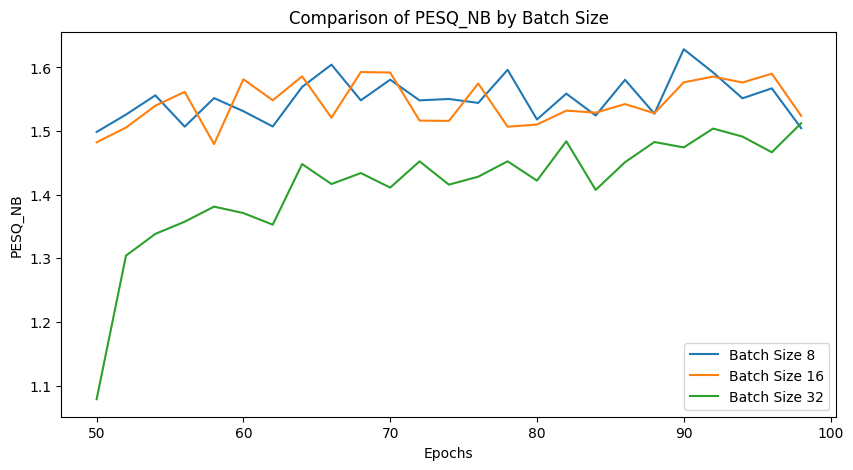

In [57]:
import matplotlib.pyplot as plt

pesq_nb_1 = [(x / 5) + 0.2 for x in final_res['batch_8']['pesq_nb']]
pesq_nb_2 = [(x / 5) + 0.2 for x in final_res['batch_16']['pesq_nb']]
pesq_nb_3 = [(x / 5) + 0.2 for x in final_res['batch_32']['pesq_nb']]

index = [(x * 2) + 50 for x in list(range(len(pesq_nb_1)))]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(index, pesq_nb_1, label='Batch Size 8')
plt.plot(index, pesq_nb_2, label='Batch Size 16')
plt.plot(index, pesq_nb_3, label='Batch Size 32')

# Adding title and labels
plt.title('Comparison of PESQ_NB by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('PESQ_NB')

# Adding legend
plt.legend()

# Showing the plot
plt.show()

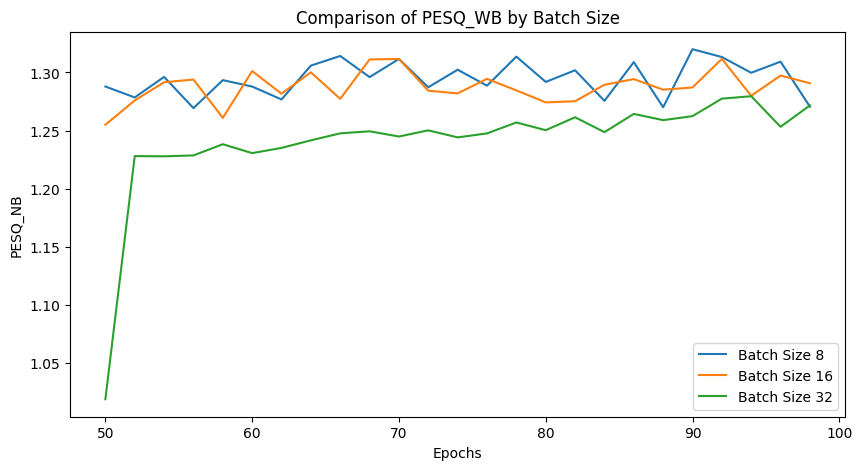

In [59]:
import matplotlib.pyplot as plt

pesq_nb_1 = [(x / 5) + 0.2 for x in final_res['batch_8']['pesq_wb']]
pesq_nb_2 = [(x / 5) + 0.2 for x in final_res['batch_16']['pesq_wb']]
pesq_nb_3 = [(x / 5) + 0.2 for x in final_res['batch_32']['pesq_wb']]

index = [(x * 2) + 50 for x in list(range(len(pesq_nb_1)))]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(index, pesq_nb_1, label='Batch Size 8')
plt.plot(index, pesq_nb_2, label='Batch Size 16')
plt.plot(index, pesq_nb_3, label='Batch Size 32')

# Adding title and labels
plt.title('Comparison of PESQ_WB by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('PESQ_NB')

# Adding legend
plt.legend()

# Showing the plot
plt.show()

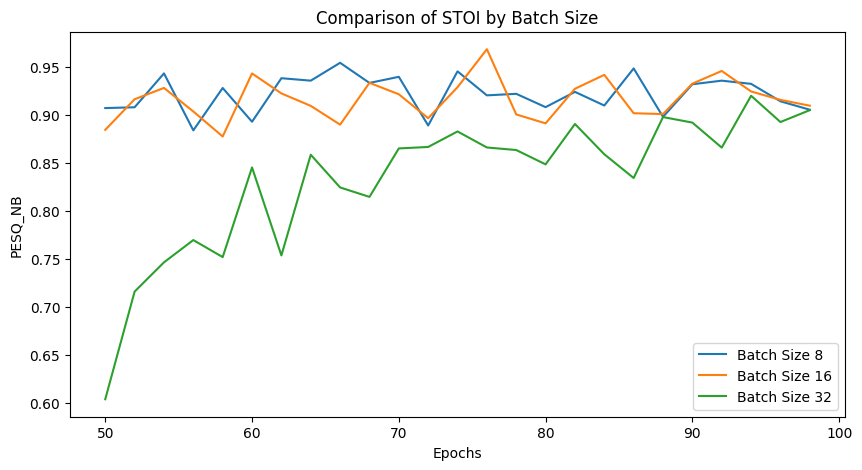

In [58]:
import matplotlib.pyplot as plt

pesq_nb_1 = [(x / 5) + 0.2 for x in final_res['batch_8']['stoi']]
pesq_nb_2 = [(x / 5) + 0.2 for x in final_res['batch_16']['stoi']]
pesq_nb_3 = [(x / 5) + 0.2 for x in final_res['batch_32']['stoi']]

index = [(x * 2) + 50 for x in list(range(len(pesq_nb_1)))]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(index, pesq_nb_1, label='Batch Size 8')
plt.plot(index, pesq_nb_2, label='Batch Size 16')
plt.plot(index, pesq_nb_3, label='Batch Size 32')

# Adding title and labels
plt.title('Comparison of STOI by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('PESQ_NB')

# Adding legend
plt.legend()

# Showing the plot
plt.show()